# Data Extraction
## Purpose
To collect data from database into a local sqllite database. This avoids maintaining a constant connection to the online private database. 

## Imports
Import needed python modules

In [1]:
import sqlite3 # for backup data
import itertools

import pandas as pd
import numpy as np
from IPython.display import display_html
from sqlalchemy import create_engine, text

from matplotlib import pyplot as plt
import seaborn as sns

#Retrieve connection sqlalchemy styled connection strings to source databases
# Exact connection parameters are proprietary and are stored locally.
from sqlconnection import connection_waterbox, connection_process
from raw_tensile_chemistry import get_sqis_tensile
from sizeconversion import frac_to_dec, frac_to_dec_str

# Global variables
# Set date start for retrieval
start_date = '2021-12-01'
local_db = 'raw_download.db'

## Retrieve the necessary Tables
Using pandas read_sql method, the three process tables are retrieved independently. There are instances where duplicates exist for the same Coil_ID, so these need to be dealt with before merging the tables together. I'll use simple sql statements to retrieve the data before performing further analysis. All of the filtering and de-duplication could be performed in the SQL statement, but would yield a very complex SQL statement.

The incoming product characteristics are stored in the `PWB1_NTM` table. The No Twist Mill (`PWB1_NTM`) is a rolling stand which precedes and feeds the waterboxes. This table contains some additional information, such as the product speed, and temperature entering the waterboxes. Material speed affects the contact time with the water in the waterboxes, so higher speeds have less contact time, and should need more water flow to compensate, to remove the same amount of heat from the product. The incoming temperature also directly affects how much water is needed to cool the product to a given temperature. 

The `Coil_ID` is used as the index and has a trailing space, which is removed in the SQL select statement. 

In [2]:
# NTM raw data
sql = f''' --begin-sql
SELECT DISTINCT
    TRIM(PWB1_NTM.[Coil_ID]) AS Coil_ID
    , PWB1_NTM.[_TimeStamp] as [Time_Stamp]
    , PWB1_NTM.[_FileName] AS [Time_TimeRange]
    , PWB1_NTM.[NTM_MatSpeed_MPS]
    , PWB1_NTM.[NTM_MatSpeed_SD]
    , PWB1_NTM.[NTM_WBValRef]
    , PWB1_NTM.[NTMST_TorquePercent]
    , PWB1_NTM.[NTMST_Torque_SD]
    , PWB1_NTM.[ANTM_Temp]
    , PWB1_NTM.[ANTM_SD] AS ANTM_Temp_SD
    , PWB1_NTM.[ANTM_TempRateOfChange] AS ANTM_Temp_RateOfChange
FROM dbo.PWB1_NTM
WHERE
    (dbo.PWB1_NTM.COIL_ID != '') AND
    PWB1_NTM._TimeStamp >= '{start_date}'
ORDER BY PWB1_NTM._TimeStamp
-- end-sql
'''
connection_str = connection_waterbox()
engine = create_engine(connection_str)
connection = engine.connect()

ntm_raw = pd.read_sql(
    text(sql), 
    connection, 
    index_col='Coil_ID'
)

connection.close()

ntm_raw.head()

Time_Stamp  \
Coil_ID                          
6262930370 2021-12-01 00:22:26   
6262930380 2021-12-01 01:16:40   
6263890050 2021-12-01 03:13:17   
6263890060 2021-12-01 03:26:27   
6263890070 2021-12-01 03:46:03   

                                               Time_TimeRange  \
Coil_ID                                                         
6262930370  Rod 01.12.21 00:22:26.359 - 01.12.21 00:23:46.521   
6262930380  Rod 01.12.21 01:16:40.692 - 01.12.21 01:17:17.413   
6263890050  Rod 01.12.21 03:13:17.304 - 01.12.21 03:14:11.801   
6263890060  Rod 01.12.21 03:26:27.526 - 01.12.21 03:27:27.960   
6263890070  Rod 01.12.21 03:46:03.501 - 01.12.21 03:47:03.790   

            NTM_MatSpeed_MPS  NTM_MatSpeed_SD  NTM_WBValRef  \
Coil_ID                                                       
6262930370           15.8699         0.001064         100.0   
6262930380           15.8699         0.001064         100.0   
6263890050           15.8699         0.001064         100.0   
6263890060           15.8699         0.001064         100.0   
6263890070           15.8699         0.001064         100.0   

            NTMST_TorquePercent  NTMST_Torque_SD    ANTM_Temp  ANTM_Temp_SD  \
Coil_ID                                                                       
6262930370              8.34403          3.49238  1800.550049      16.06020   
6262930380              2.74629          8.77676  1659.459961      15.24590   
6263890050             16.23250          3.79989  1858.849976      13.58290   
6263890060             17.45200          4.12463  1788.760010      17.53120   
6263890070             17.83860          4.23196  1778.130005       9.53776   

            ANTM_Temp_RateOfChange  
Coil_ID                             
6262930370               -0.729405  
6262930380              -12.127100  
6263890050               -0.464412  
6263890060                0.034658  
6263890070               -0.168347

In [3]:
ntm_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125022 entries, 6262930370 to 6346160200
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Time_Stamp              125022 non-null  datetime64[ns]
 1   Time_TimeRange          125022 non-null  object        
 2   NTM_MatSpeed_MPS        124929 non-null  float64       
 3   NTM_MatSpeed_SD         124929 non-null  float64       
 4   NTM_WBValRef            124929 non-null  float64       
 5   NTMST_TorquePercent     124929 non-null  float64       
 6   NTMST_Torque_SD         124929 non-null  float64       
 7   ANTM_Temp               123661 non-null  float64       
 8   ANTM_Temp_SD            123680 non-null  float64       
 9   ANTM_Temp_RateOfChange  123661 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(1)
memory usage: 10.5+ MB


Waterbox information is saved to the `WB` table. It contains the core process variables under study. There are five waterboxes, used to achieve the final temperature. As stated previously, the Operators can choose any configuration which yields the desired output. 

In [4]:
# Waterbox 
sql = f''' --begin-sql
SELECT DISTINCT
    TRIM(WB.[Coil_ID]) AS Coil_ID
    , WB.[_TimeStamp] as [Time_Stamp]
    , WB.[_FileName] AS [Time_TimeRange]
    , WB.[WB1_Select]
    , WB.[WB1_CoolValOpn]
    , WB.[WB1_WStripValOpn]
    , WB.[WB1_Zone1ValOpn]
    , WB.[WB1_Zone2ValOpn]
    , WB.[WB1_AirStripValOpn]
    --, WB.[WB1_TempControlSel]
    --, WB.[WB1_TempControlSP]
    , WB.[WB1_FlowControlSel]
    , WB.[WB1_FlowControlSP]
    , WB.[WB1_WaterFlowTr_GPM]
    , WB.[WB1_WaterFlowTr_SD]
    , WB.[WB1_WaterFlowRef_GPM] as [WB1_WaterFlowRef_%]
    , WB.[WB1_WaterFlowRef_SD]
    , WB.[WB1_LinePressTr_PSI]
    , WB.[WB2_Select]
    , WB.[WB2_CoolValOpn]
    , WB.[WB2_WStripValOpn]
    , WB.[WB2_Zone1ValOpn]
    , WB.[WB2_Zone2ValOpn]
    , WB.[WB2_AirStripValOpn]
    --, WB.[WB2_TempControlSel]
    --, WB.[WB2_TempControlSP]
    , WB.[WB2_FlowControlSel]
    , WB.[WB2_FlowControlSP]
    , WB.[WB2_WaterFlowTr_GPM]
    , WB.[WB2_WaterFlowTr_SD]
    , WB.[WB2_WaterFlowRef_GPM] as [WB2_WaterFlowRef_%]
    , WB.[WB2_WaterFlowRef_SD]
    , WB.[WB2_LinePressTr_PSI]
    , WB.[WB3_Select]
    , WB.[WB3_CoolValOpn]
    , WB.[WB3_WStripValOpn]
    , WB.[WB3_Zone1ValOpn]
    , WB.[WB3_Zone2ValOpn]
    , WB.[WB3_AirStripValOpn]
    --, WB.[WB3_TempControlSel]
    --, WB.[WB3_TempControlSP]
    , WB.[WB3_FlowControlSel]
    , WB.[WB3_FlowControlSP]
    , WB.[WB3_WaterFlowTr_GPM]
    , WB.[WB3_WaterFlowTr_SD]
    , WB.[WB3_WaterFlowRef_GPM] as [WB3_WaterFlowRef_%]
    , WB.[WB3_WaterFlowRef_SD]
    , WB.[WB3_LinePressTr_PSI]
    --, WB.[AWB3_Temp]
    --, WB.[AWB3_SD]
    --, WB.[AWB3_TempRateOfChange]
    , WB.[WB4_Select]
    , WB.[WB4_CoolValOpn]
    , WB.[WB4_WStripValOpn]
    , WB.[WB4_Zone1ValOpn]
    , WB.[WB4_Zone2ValOpn]
    , WB.[WB4_Zone3ValOpn]
    , WB.[WB4_AirStripValOpn]
    --, WB.[WB4_TempControlSel]
    --, WB.[WB4_TempControlSP]
    , WB.[WB4_FlowControlSel]
    , WB.[WB4_FlowControlSP]
    , WB.[WB4_WaterFlowTr_GPM]
    , WB.[WB4_WaterFlowTr_SD]
    , WB.[WB4_WaterFlowRef_GPM] as [WB4_WaterFlowRef_%]
    , WB.[WB4_WaterFlowRef_SD]
    , WB.[WB4_LinePressTr_PSI]
    --, WB.[AWB4_Temp]
    --, WB.[AWB4_SD]
    --, WB.[AWB4_TempRateOfChange]
    , WB.[WB5_Select]
    , WB.[WB5_CoolValOpn]
    , WB.[WB5_WStripValOpn]
    , WB.[WB5_Zone1ValOpn]
    , WB.[WB5_Zone2ValOpn]
    , WB.[WB5_Zone3ValOpn]
    , WB.[WB5_AirStripValOpn]
    --, WB.[WB5_TempControlSel]
    --, WB.[WB5_TempControlSP]
    , WB.[WB5_FlowControlSel]
    , WB.[WB5_FlowControlSP]
    , WB.[WB5_WaterFlowTr_GPM]
    , WB.[WB5_WaterFlowTr_SD]
    , WB.[WB5_WaterFlowRef_GPM] as [WB5_WaterFlowRef_%]
    , WB.[WB5_WaterFlowRef_SD]
    , WB.[WB5_LinePress_PSI] as [WB5_LinePressTr_PSI]
FROM dbo.WB
WHERE
    (dbo.WB.COIL_ID != '') AND
    dbo.WB._TimeStamp >= '{start_date}' 
order by WB._TimeStamp
-- end-sql
'''
connection_str = connection_waterbox()
engine = create_engine(connection_str)
connection = engine.connect()

wb_raw = pd.read_sql(
    text(sql), 
    connection, 
    index_col='Coil_ID'
)

connection.close()

wb_raw.head()

Time_Stamp  \
Coil_ID                          
6262930370 2021-12-01 00:22:28   
6262930380 2021-12-01 01:16:43   
6263890050 2021-12-01 03:13:20   
6263890060 2021-12-01 03:26:30   
6263890070 2021-12-01 03:46:06   

                                               Time_TimeRange  WB1_Select  \
Coil_ID                                                                     
6262930370  Rod 01.12.21 00:22:28.935 - 01.12.21 00:22:49.896         0.0   
6262930380  Rod 01.12.21 01:16:43.572 - 01.12.21 01:18:43.572         0.0   
6263890050  Rod 01.12.21 03:13:20.184 - 01.12.21 03:14:13.849         0.0   
6263890060  Rod 01.12.21 03:26:30.599 - 01.12.21 03:27:29.944         0.0   
6263890070  Rod 01.12.21 03:46:06.477 - 01.12.21 03:47:05.774         0.0   

            WB1_CoolValOpn  WB1_WStripValOpn  WB1_Zone1ValOpn  \
Coil_ID                                                         
6262930370             0.0               0.0              1.0   
6262930380             0.0               0.0              1.0   
6263890050             0.0               0.0              1.0   
6263890060             0.0               0.0              1.0   
6263890070             0.0               0.0              1.0   

            WB1_Zone2ValOpn  WB1_AirStripValOpn  WB1_FlowControlSel  \
Coil_ID                                                               
6262930370              1.0                 0.0                 0.0   
6262930380              1.0                 0.0                 0.0   
6263890050              1.0                 0.0                 0.0   
6263890060              1.0                 0.0                 0.0   
6263890070              1.0                 0.0                 0.0   

            WB1_FlowControlSP  ...  WB5_Zone2ValOpn  WB5_Zone3ValOpn  \
Coil_ID                        ...                                     
6262930370                0.0  ...              0.0              0.0   
6262930380                0.0  ...              0.0              0.0   
6263890050                0.0  ...              0.0              0.0   
6263890060                0.0  ...              0.0              0.0   
6263890070                0.0  ...              0.0              0.0   

            WB5_AirStripValOpn  WB5_FlowControlSel  WB5_FlowControlSP  \
Coil_ID                                                                 
6262930370                 0.0                 0.0                8.0   
6262930380                 0.0                 0.0                8.0   
6263890050                 0.0                 0.0                8.0   
6263890060                 0.0                 0.0                8.0   
6263890070                 0.0                 0.0                8.0   

            WB5_WaterFlowTr_GPM  WB5_WaterFlowTr_SD  WB5_WaterFlowRef_%  \
Coil_ID                                                                   
6262930370            -0.015055            0.011456                 0.0   
6262930380            -0.010468            0.007692                 0.0   
6263890050            -0.022189            0.006234                 0.0   
6263890060            -0.028717            0.006255                 0.0   
6263890070            -0.025735            0.007666                 0.0   

            WB5_WaterFlowRef_SD  WB5_LinePressTr_PSI  
Coil_ID                                               
6262930370                  0.0            81.961601  
6262930380                  0.0            81.595100  
6263890050                  0.0            81.453400  
6263890060                  0.0            82.224998  
6263890070                  0.0            81.359398  

[5 rows x 69 columns]

In [5]:
wb_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 124145 entries, 6262930370 to 6346160200
Data columns (total 69 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   Time_Stamp           124145 non-null  datetime64[ns]
 1   Time_TimeRange       124145 non-null  object        
 2   WB1_Select           124145 non-null  float64       
 3   WB1_CoolValOpn       124145 non-null  float64       
 4   WB1_WStripValOpn     124145 non-null  float64       
 5   WB1_Zone1ValOpn      124145 non-null  float64       
 6   WB1_Zone2ValOpn      124145 non-null  float64       
 7   WB1_AirStripValOpn   124145 non-null  float64       
 8   WB1_FlowControlSel   124145 non-null  float64       
 9   WB1_FlowControlSP    124145 non-null  float64       
 10  WB1_WaterFlowTr_GPM  124145 non-null  float64       
 11  WB1_WaterFlowTr_SD   124145 non-null  float64       
 12  WB1_WaterFlowRef_%   124145 non-null  float64       
 13  WB1_Wa

The output temperature (response) is saved to the `LH` table. The laying head (`LH`) is the next production unit after the waterboxes. It contains the output variable, final temperature. It is retrieved using pandas read_sql. The formatting is improved by renaming columns and dropping system columns. 

In [6]:
sql = f''' --begin-sql
SELECT
    TRIM(LH.[Coil_ID]) AS Coil_ID
    , LH.[_TimeStamp] as [Time_Stamp]
    , LH.[_FileName] AS [Time_TimeRange]
    , LH.[LH_Temp]
    , LH.[LH_SD] as LH_Temp_SD
    , LH.[LH_TempRateOfChange] AS LH_Temp_RateOfChange
FROM dbo.LH
WHERE
    (LH.COIL_ID != '') AND
    LH._TimeStamp >= '{start_date}'
ORDER BY LH._TimeStamp
-- end-sql
'''
connection_str = connection_waterbox()
engine = create_engine(connection_str)
connection = engine.connect()

lh_raw = pd.read_sql(
    text(sql), 
    connection, 
    index_col='Coil_ID'
)

connection.close()

lh_raw.head()

Time_Stamp  \
Coil_ID                          
6263890070 2021-12-01 03:46:15   
6263890090 2021-12-01 03:57:19   
6263890100 2021-12-01 03:58:50   
6263890130 2021-12-01 04:03:59   
6263890340 2021-12-01 04:31:49   

                                               Time_TimeRange      LH_Temp  \
Coil_ID                                                                      
6263890070  Rod 01.12.21 03:46:15.125 - 01.12.21 03:47:12.838  1758.589966   
6263890090  Rod 01.12.21 03:57:19.409 - 01.12.21 03:58:16.850  1761.780029   
6263890100  Rod 01.12.21 03:58:50.387 - 01.12.21 03:59:48.388  1754.020020   
6263890130  Rod 01.12.21 04:03:59.177 - 01.12.21 04:04:56.426  1756.199951   
6263890340  Rod 01.12.21 04:31:49.640 - 01.12.21 04:32:47.737  1757.500000   

            LH_Temp_SD  LH_Temp_RateOfChange  
Coil_ID                                       
6263890070    11.12110             -0.096117  
6263890090    11.19780             -0.300954  
6263890100     9.86034             -0.242252  
6263890130    10.51100             -0.327176  
6263890340     7.03784             -0.092242

In [7]:
lh_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127219 entries, 6263890070 to 6346160200
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time_Stamp            127219 non-null  datetime64[ns]
 1   Time_TimeRange        127219 non-null  object        
 2   LH_Temp               126728 non-null  float64       
 3   LH_Temp_SD            127168 non-null  float64       
 4   LH_Temp_RateOfChange  126727 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 5.8+ MB


Categorical data is saved in a separate process database under a joining of `Coil` and `Schedule` tables. These tables are saved in a different target database. There are two functions called to get the size converted into more manageable (sortable) format. These were written previously.

In [8]:
# Categorical Table
sql = f'''--begin-sql
    SELECT DISTINCT
        --CAST(
            CONCAT(
                Coil.[HeatNumber]
                , RIGHT('000' + CAST([Sequence] As varchar), 3)
                , [SplitSequence]
            --) AS BIGINT
        ) AS Coil_ID
        ,[Coil].[Grade] AS [Coil_Grade]
        ,[Coil].[CoilSize] AS [Coil_Size]
        ,[RolledTime] AS [Time_Rolled]
    FROM [Coil] 
        INNER JOIN [Schedule] ON [Coil].[ScheduleID] = [Schedule].[ID]
    WHERE RolledTime >= '{start_date}'
    order by Time_rolled
    --end-sql
'''

connection_str = connection_process()
engine = create_engine(connection_str)
connection = engine.connect()

process_raw = pd.read_sql(
    text(sql), 
    connection,
    index_col='Coil_ID',
)

process_raw['Coil_Size_Dec'] = process_raw['Coil_Size'].map(frac_to_dec, na_action='ignore')
process_raw['Coil_Size_Frac'] = process_raw['Coil_Size']
process_raw['Coil_Size'] = process_raw['Coil_Size'].map(frac_to_dec_str, na_action='ignore')

connection.close()

process_raw.head()

Coil_Grade Coil_Size         Time_Rolled  Coil_Size_Dec  \
Coil_ID                                                              
6262930370      SCRAP        #6 2021-12-01 00:19:36            NaN   
6262930380      SCRAP        #6 2021-12-01 01:13:49            NaN   
6263890050   RB-15-37        #6 2021-12-01 03:10:33            NaN   
6263890060   RB-15-37        #6 2021-12-01 03:23:45            NaN   
6263890070   RB-15-37        #6 2021-12-01 03:43:22            NaN   

           Coil_Size_Frac  
Coil_ID                    
6262930370             #6  
6262930380             #6  
6263890050             #6  
6263890060             #6  
6263890070             #6

!!!! The final table .....

In [9]:
ten_chem_raw = get_sqis_tensile(start=start_date)
ten_chem_raw.head()

c:\Users\blakamp\Box\Documents\Regis\MSDS692-696 Practicum\raw_tensile_chemistry.py:554: FutureWarning: The default value of regex will change from True to False in a future version.
  .str.replace('\.','')


Tensile                                                       ... Chem  \
  TestNum Coil DimIni DimRed  YS      UT  EL     RA     OV  WT  ...    H   
0     1.0  1.0  0.562  0.434 NaN  113.98 NaN  40.29  0.006 NaN  ...  0.0   
1     2.0  2.0  0.562  0.424 NaN  112.25 NaN  43.11  0.006 NaN  ...  0.0   
2     3.0  3.0  0.562  0.432 NaN  113.06 NaN  40.98  0.006 NaN  ...  0.0   
3     4.0  4.0  0.562  0.431 NaN  114.28 NaN  41.10  0.006 NaN  ...  0.0   
4     5.0  5.0  0.562  0.420 NaN  115.19 NaN  44.20  0.006 NaN  ...  0.0   

         MTR                                                           Coil  \
        Date     Status        CreationDate             Updated          ID   
0 2021-12-01  OK-TESTED 2021-12-01 13:49:51 2021-12-01 13:49:51  6266060010   
1 2021-12-01  OK-TESTED 2021-12-01 13:49:51 2021-12-01 13:49:51  6266060020   
2 2021-12-01  OK-TESTED 2021-12-01 13:49:51 2021-12-01 13:49:51  6266060030   
3 2021-12-01  OK-TESTED 2021-12-01 13:49:51 2021-12-01 13:49:51  6266060040   
4 2021-12-01  OK-TESTED 2021-12-01 13:49:51 2021-12-01 13:49:51  6266060050   

  Schedule               Tensile      Chem  
  Size_Dec Size_Frac         PTS        Di  
0   0.5625      9/16  107.055186  1.064379  
1   0.5625      9/16  107.055186  1.064379  
2   0.5625      9/16  107.055186  1.064379  
3   0.5625      9/16  107.055186  1.064379  
4   0.5625      9/16  107.055186  1.064379  

[5 rows x 55 columns]

## Backup Tables
Using sqlite3 library, copies of each table is saved for offline retrieval, and uploading for share. 

In [10]:
con = sqlite3.connect(local_db)
ntm_rows = ntm_raw.to_sql('NTM', con, if_exists='replace')
wb_rows = wb_raw.to_sql('Waterbox', con, if_exists='replace')
lh_rows = lh_raw.to_sql('LH', con, if_exists='replace')
proc_rows = process_raw.to_sql('Process', con, if_exists='replace')


# convert multiindex to flat before upload
ten_chem_raw.columns = [
    f'{x}_{y}' for x, y in 
    ten_chem_raw.columns.to_list()
]
ten_rows = ten_chem_raw.to_sql('Ten_Chem', con, if_exists='replace')
f'Records uploaded: NTM {ntm_rows}, Waterbox {wb_rows}, LH {lh_rows}, Process {proc_rows}, Tensile/Chemistry {ten_rows}'


'Records uploaded: NTM 125022, Waterbox 124145, LH 127219, Process 133900, Tensile/Chemistry 20164'

## Retrieve Backups if Necessary

In [2]:
con = sqlite3.connect(local_db)
sql = 'Select * FROM ntm'
ntm_raw = pd.read_sql(sql, con, parse_dates='Time_Stamp').set_index('Coil_ID')

sql = 'Select * FROM Waterbox'
wb_raw = pd.read_sql(sql, con, parse_dates='Time_Stamp').set_index('Coil_ID')

sql = 'Select * FROM LH'
lh_raw = pd.read_sql(sql, con, parse_dates='Time_Stamp').set_index('Coil_ID')

sql = 'Select * FROM Process'
process_raw = pd.read_sql(sql, con, parse_dates='Time_Rolled').set_index('Coil_ID')

sql = 'Select * FROM Ten_Chem'
ten_chem_raw = pd.read_sql(sql, con, parse_dates='MTR_Date').set_index('Coil_ID')

# Correct multiindex for `ten_chem_raw`
#ten_chem_raw.columns = pd.MultiIndex.from_tuples(
#    ten_chem_raw.columns.str.split('_',1).tolist()
#)



# Exploration of Data

## Deduplication
The system which collects the data is tuned to look for certain thresholds being met in order to start recording data. Sometimes during collection, the active recording may 'hiccup' because of a threshold not being met. This results in multiple records being generated for the same coil. The start and stop time are embedded in the _FileName filed from the database. Performing some manipulation of these time stamps yields how long the data was recorded. Basic filtering for very small data sets, and selection of the longest value can reduce the repeated coil IDs. If the data collected is too short, it poorly represents what was experienced by the coil. 


In [3]:
# Extract recording time stamps. Calculate the recording time.
for df in (ntm_raw, wb_raw, lh_raw):
    time_range = df['Time_TimeRange'].str.split(' ', expand=True)
    df[('Time_RecStart')] = pd.to_datetime(time_range[1], format='%d.%m.%y') + pd.to_timedelta(time_range[2])
    df[('Time_RecEnd')] = pd.to_datetime(time_range[4], format='%d.%m.%y') + pd.to_timedelta(time_range[5])
    df[('Time_TimeRange')] = df[('Time_RecEnd')] - df[('Time_RecStart')]

Text(0.5, 0, 'Recording Length (s)')

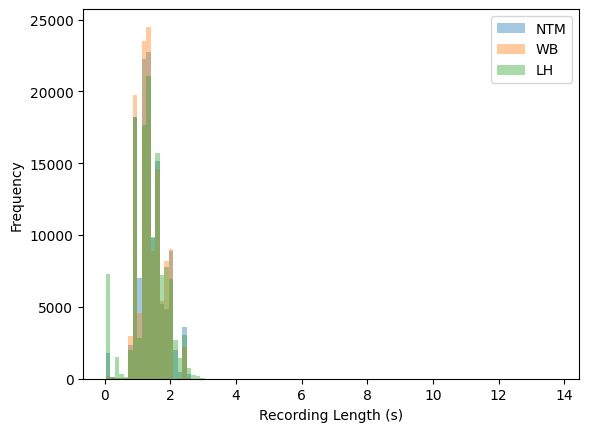

In [4]:
ax = pd.concat(
[
    ntm_raw['Time_TimeRange'].dt.total_seconds().multiply(1/60).reset_index(drop=True),#.rename('NTM').to_frame(),
    wb_raw['Time_TimeRange'].dt.total_seconds().multiply(1/60).reset_index(drop=True),#.rename('WB').to_frame(),
    lh_raw['Time_TimeRange'].dt.total_seconds().multiply(1/60).reset_index(drop=True)#.rename('LH').to_frame()
], axis=1, keys=['NTM', 'WB', 'LH']
).plot.hist(bins = 100, alpha=.4)
ax.set_xlabel('Recording Length (s)');


After reviewing the data distribution, there is a natural break at around 45 seconds between a very low population of "short" recording periods and the majority of them at 1 to 3 minutes. There are also recordings which lasted much longer than 3 minutes. These will also be removed, as the time indicates that there was an issue with that coil run. Generally if a coil triggered the sensors that long, it stopped and is not representative of the continuous process.

In [5]:
ntm_trim = ntm_raw[(ntm_raw['Time_TimeRange'].dt.total_seconds() > 45) & (ntm_raw['Time_TimeRange'].dt.total_seconds() < 150)]
wb_trim = wb_raw[(wb_raw['Time_TimeRange'].dt.total_seconds() > 45) & (wb_raw['Time_TimeRange'].dt.total_seconds() < 150)]
lh_trim = lh_raw[(lh_raw['Time_TimeRange'].dt.total_seconds() > 45) & (lh_raw['Time_TimeRange'].dt.total_seconds() < 170)]

Additional review of duplicate coils, indicate there are 300-800 repeated coils identifiers. Looking at the source tables, the data collection program appears to have collected an initial coil's data and then mis-labeled subsequent coils as the same value. With this in mind, I believe that only the first coil (as determined by time stamp) is correctly identified, and there is no time effective method to recover the correct identifier. The three process data tables will drop duplicated values (excluding the first instance).

In [6]:
ntm_dedup = ntm_trim.sort_values('Time_RecStart').reset_index()
ntm_dedup = ntm_dedup.drop_duplicates(subset='Coil_ID').set_index('Coil_ID')

wb_dedup = wb_trim.sort_values('Time_RecStart').reset_index()
wb_dedup = wb_dedup.drop_duplicates(subset='Coil_ID').set_index('Coil_ID')

lh_dedup = lh_trim.sort_values('Time_RecStart').reset_index()
lh_dedup = lh_dedup.drop_duplicates(subset='Coil_ID').set_index('Coil_ID')

## Merge Tables
The numerical process data from three de-duplicated tables will be left joined to process categorical data, using the Coil_ID in each. The collection method of the numerical process data can lead to some data loss. The categorical process data uses a more accurate tracking system. 

In [7]:
merged_raw = (
    process_raw
    .join(ntm_dedup)
    .join(wb_dedup, lsuffix='_ntm', rsuffix='_wb')
    .join(lh_dedup.add_suffix('_lh'))
    )

# Convert column headers
merged_raw.columns = pd.MultiIndex.from_tuples(
    merged_raw.columns.str.split('_', n=1).tolist()
)

In [8]:
print(f'NTM frame size {ntm_dedup.shape}.',
    f'WB frame size {wb_dedup.shape}.',
    f'LH frame size {lh_dedup.shape}.',
    f'process frame size {process_raw.shape}.')

NTM frame size (122179, 12). WB frame size (122979, 71). LH frame size (117192, 7). process frame size (133900, 5).


All duplicate coils have been removed.

In [9]:
merged_raw.index.value_counts().head(5)

6262930370    1
6322730080    1
6322730060    1
6322730050    1
6322730040    1
Name: Coil_ID, dtype: int64

## Initial Characteristic Review


In [10]:
merged_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 133900 entries, 6262930370 to 6330490470
Data columns (total 95 columns):
 #   Column                     Non-Null Count   Dtype          
---  ------                     --------------   -----          
 0   (Coil, Grade)              133900 non-null  object         
 1   (Coil, Size)               133898 non-null  object         
 2   (Time, Rolled)             133900 non-null  datetime64[ns] 
 3   (Coil, Size_Dec)           112771 non-null  float64        
 4   (Coil, Size_Frac)          133900 non-null  object         
 5   (Time, Stamp_ntm)          122179 non-null  datetime64[ns] 
 6   (Time, TimeRange_ntm)      122179 non-null  timedelta64[ns]
 7   (NTM, MatSpeed_MPS)        122087 non-null  float64        
 8   (NTM, MatSpeed_SD)         122087 non-null  float64        
 9   (NTM, WBValRef)            122087 non-null  float64        
 10  (NTMST, TorquePercent)     122087 non-null  float64        
 11  (NTMST, Torque_SD)         1220

Look closer at which columns contain null values !!!! improve or delete this section

In [11]:
merged_raw.isna().sum()[merged_raw.isna().sum() > 0]

Coil  Size                     2
      Size_Dec             21129
Time  Stamp_ntm            11721
      TimeRange_ntm        11721
NTM   MatSpeed_MPS         11813
                           ...  
LH    Temp                 17102
      Temp_SD              16708
      Temp_RateOfChange    17103
Time  RecStart_lh          16708
      RecEnd_lh            16708
Length: 92, dtype: int64

!!!!! To understand the impact of cooling, having a starting and finishing temperature will be important. The ANTM_TEMP (after NTM temperature) is missing almost 1400 values, but is only a minor loss compared to the 130000 initial records. 

Because the data is missing, the initial review of each column will ignore it. In future analyses these records will be dropped. 

Next each level 0 grouped section can be reviewed for descriptive statistics.

In [12]:
for section in merged_raw.columns.get_level_values(0).unique():
    print(f'Section: {section}')
    display_html(merged_raw[section].describe(datetime_is_numeric=True))

Section: Coil


Size_Dec 
 
 
 
 
 count 
 112771.000000 
 
 
 mean 
 0.334408 
 
 
 std 
 0.110718 
 
 
 min 
 0.218750 
 
 
 25% 
 0.250000 
 
 
 50% 
 0.312500 
 
 
 75% 
 0.437500 
 
 
 max 
 0.750000

Section: Time


Rolled 
 Stamp_ntm 
 TimeRange_ntm 
 RecStart_ntm 
 RecEnd_ntm 
 Stamp_wb 
 TimeRange_wb 
 RecStart_wb 
 RecEnd_wb 
 Stamp_lh 
 TimeRange_lh 
 RecStart_lh 
 RecEnd_lh 
 
 
 
 
 count 
 133900 
 122179 
 122179 
 122179 
 122179 
 122979 
 122979 
 122979 
 122979 
 117192 
 117192 
 117192 
 117192 
 
 
 mean 
 2022-06-17 21:42:03.698013184 
 2022-06-18 20:06:39.783874816 
 0 days 00:01:24.421922130 
 2022-06-18 20:06:40.283583744 
 2022-06-18 20:08:04.705505536 
 2022-06-19 04:21:57.009440768 
 0 days 00:01:23.214293318 
 2022-06-19 04:21:57.509284096 
 2022-06-19 04:23:20.723577600 
 2022-06-24 11:57:50.071976192 
 0 days 00:01:27.417919004 
 2022-06-24 11:57:50.571877632 
 2022-06-24 11:59:17.989796864 
 
 
 min 
 2021-12-01 00:19:36 
 2021-12-01 00:22:26 
 0 days 00:00:45.024000 
 2021-12-01 00:22:26.359000 
 2021-12-01 00:23:46.521000 
 2021-12-01 01:16:43 
 0 days 00:00:45.168000 
 2021-12-01 01:16:43.572000 
 2021-12-01 01:18:43.572000 
 2021-12-01 03:46:15 
 0 days 00:00:45.217000 
 2021-12-01 03:46:15.125000 
 2021-12-01 03:47:12.838000 
 
 
 25% 
 2022-03-17 09:51:25 
 2022-03-17 17:08:51 
 0 days 00:01:09.985000 
 2022-03-17 17:08:51.665499904 
 2022-03-17 17:10:16.299000064 
 2022-03-17 14:19:04.500000 
 0 days 00:01:09.617000 
 2022-03-17 14:19:05.046000128 
 2022-03-17 14:20:27.871000064 
 2022-03-25 06:20:34 
 0 days 00:01:10.529000 
 2022-03-25 06:20:34.712249856 
 2022-03-25 06:22:56.078249984 
 
 
 50% 
 2022-06-15 06:03:04 
 2022-06-16 01:42:06 
 0 days 00:01:19.457000 
 2022-06-16 01:42:06.153999872 
 2022-06-16 01:43:15.835000064 
 2022-06-16 05:34:00 
 0 days 00:01:18.017000 
 2022-06-16 05:34:00.193999872 
 2022-06-16 05:35:09.267000064 
 2022-06-24 12:49:21.500000 
 0 days 00:01:23.106000 
 2022-06-24 12:49:21.975500032 
 2022-06-24 12:50:41.440499968 
 
 
 75% 
 2022-09-15 00:25:11.500000 
 2022-09-14 02:55:11.500000 
 0 days 00:01:36.642000 
 2022-09-14 02:55:12.275000064 
 2022-09-14 02:56:30.564499968 
 2022-09-14 13:37:08 
 0 days 00:01:35.617500 
 2022-09-14 13:37:08.735000064 
 2022-09-14 13:38:31.872999936 
 2022-09-15 22:18:53.500000 
 0 days 00:01:43.186000 
 2022-09-15 22:18:54.352499968 
 2022-09-15 22:20:04.342250240 
 
 
 max 
 2023-01-31 14:23:14 
 2023-01-27 17:15:53 
 0 days 00:02:29.987000 
 2023-01-27 17:15:53.168000 
 2023-01-27 17:17:03.649000 
 2023-01-27 17:15:54 
 0 days 00:02:29.954000 
 2023-01-27 17:15:54.992000 
 2023-01-27 17:17:04.657000 
 2023-01-27 17:16:00 
 0 days 00:02:49.875000 
 2023-01-27 17:16:00.264000 
 2023-01-27 17:17:09.881000 
 
 
 std 
 NaN 
 NaN 
 0 days 00:00:22.721903655 
 NaN 
 NaN 
 NaN 
 0 days 00:00:21.543564975 
 NaN 
 NaN 
 NaN 
 0 days 00:00:24.277426302 
 NaN 
 NaN

Section: NTM


MatSpeed_MPS 
 MatSpeed_SD 
 WBValRef 
 
 
 
 
 count 
 122087.000000 
 122087.000000 
 122087.000000 
 
 
 mean 
 66.585790 
 0.002009 
 35.860580 
 
 
 std 
 30.610943 
 0.004732 
 27.761726 
 
 
 min 
 12.161500 
 0.000000 
 0.000000 
 
 
 25% 
 33.014900 
 0.000000 
 11.049100 
 
 
 50% 
 71.612801 
 0.000000 
 37.203201 
 
 
 75% 
 96.519997 
 0.000000 
 59.056000 
 
 
 max 
 116.839996 
 0.167096 
 100.000000

Section: NTMST


TorquePercent 
 Torque_SD 
 
 
 
 
 count 
 122087.000000 
 122087.000000 
 
 
 mean 
 38.454601 
 8.907018 
 
 
 std 
 12.324060 
 3.985578 
 
 
 min 
 -3.660720 
 0.000000 
 
 
 25% 
 26.930300 
 5.099295 
 
 
 50% 
 42.060799 
 8.822850 
 
 
 75% 
 46.939201 
 11.900500 
 
 
 max 
 65.405602 
 27.793301

Section: ANTM


Temp 
 Temp_SD 
 Temp_RateOfChange 
 
 
 
 
 count 
 121896.000000 
 121869.000000 
 121896.000000 
 
 
 mean 
 1819.035200 
 8.882702 
 -0.034905 
 
 
 std 
 53.062660 
 3.393605 
 2.228298 
 
 
 min 
 1528.469971 
 0.000000 
 -15.558900 
 
 
 25% 
 1783.079956 
 6.635300 
 -0.100457 
 
 
 50% 
 1813.089966 
 8.308500 
 -0.044790 
 
 
 75% 
 1848.780029 
 10.376400 
 0.018466 
 
 
 max 
 2011.280029 
 72.282204 
 776.127014

Section: WB1


Select 
 CoolValOpn 
 WStripValOpn 
 Zone1ValOpn 
 Zone2ValOpn 
 AirStripValOpn 
 FlowControlSel 
 FlowControlSP 
 WaterFlowTr_GPM 
 WaterFlowTr_SD 
 WaterFlowRef_% 
 WaterFlowRef_SD 
 LinePressTr_PSI 
 
 
 
 
 count 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 
 
 mean 
 0.181317 
 0.167964 
 0.167940 
 0.918179 
 0.943319 
 0.170052 
 0.181287 
 31.044739 
 33.370744 
 0.315344 
 15.359814 
 0.054893 
 39.363805 
 
 
 std 
 0.385206 
 0.356946 
 0.356897 
 0.274073 
 0.231208 
 0.361362 
 0.385178 
 45.616133 
 36.243651 
 1.069697 
 15.117801 
 0.318102 
 33.432529 
 
 
 min 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 -0.071221 
 0.002015 
 0.000000 
 0.000000 
 -2.008740 
 
 
 25% 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 0.043024 
 0.004589 
 0.000000 
 0.000000 
 5.932400 
 
 
 50% 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 25.057301 
 0.098819 
 16.050400 
 0.000000 
 45.584301 
 
 
 75% 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 1.000000 
 0.000000 
 0.000000 
 70.000000 
 54.150150 
 0.171564 
 21.021299 
 0.002454 
 75.895298 
 
 
 max 
 1.000000 
 0.973470 
 0.972937 
 1.000000 
 1.000000 
 0.974790 
 1.000000 
 200.707993 
 317.178986 
 90.989403 
 97.083199 
 49.930302 
 86.465500

Section: WB2


Select 
 CoolValOpn 
 WStripValOpn 
 Zone1ValOpn 
 Zone2ValOpn 
 AirStripValOpn 
 FlowControlSel 
 FlowControlSP 
 WaterFlowTr_GPM 
 WaterFlowTr_SD 
 WaterFlowRef_% 
 WaterFlowRef_SD 
 LinePressTr_PSI 
 
 
 
 
 count 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 
 
 mean 
 0.501393 
 0.468235 
 0.468149 
 0.942808 
 0.946617 
 0.473600 
 0.501373 
 50.653259 
 51.852053 
 0.645454 
 14.311120 
 0.170795 
 35.039368 
 
 
 std 
 0.499945 
 0.467112 
 0.467027 
 0.232187 
 0.224777 
 0.472410 
 0.499945 
 43.004803 
 53.600161 
 1.542659 
 13.075163 
 0.423231 
 27.248278 
 
 
 min 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 -0.178452 
 0.001615 
 0.000000 
 0.000000 
 -2.114430 
 
 
 25% 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 1.000000 
 0.000000 
 0.000000 
 0.000000 
 8.624120 
 0.073783 
 0.000000 
 0.000000 
 13.897350 
 
 
 50% 
 1.000000 
 0.875310 
 0.875101 
 1.000000 
 1.000000 
 0.889923 
 1.000000 
 55.000000 
 50.452400 
 0.279257 
 14.022700 
 0.006144 
 26.866899 
 
 
 75% 
 1.000000 
 0.934902 
 0.934768 
 1.000000 
 1.000000 
 0.945822 
 1.000000 
 80.000000 
 75.567101 
 0.761324 
 20.288401 
 0.284764 
 64.962749 
 
 
 max 
 1.000000 
 0.973470 
 0.972804 
 1.000000 
 1.000000 
 0.980662 
 1.000000 
 250.000000 
 343.915985 
 125.941002 
 100.000000 
 38.203300 
 87.858200

Section: WB3


Select 
 CoolValOpn 
 WStripValOpn 
 Zone1ValOpn 
 Zone2ValOpn 
 AirStripValOpn 
 FlowControlSel 
 FlowControlSP 
 WaterFlowTr_GPM 
 WaterFlowTr_SD 
 WaterFlowRef_% 
 WaterFlowRef_SD 
 LinePressTr_PSI 
 
 
 
 
 count 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 
 
 mean 
 0.746904 
 0.695804 
 0.695686 
 0.861030 
 0.873714 
 0.703960 
 0.746804 
 56.992624 
 67.919062 
 0.459867 
 17.229592 
 0.131544 
 25.088182 
 
 
 std 
 0.434742 
 0.405513 
 0.405445 
 0.345903 
 0.332164 
 0.410131 
 0.434793 
 36.522994 
 33.831204 
 1.128585 
 11.119144 
 0.401855 
 19.845409 
 
 
 min 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 -0.117479 
 0.001574 
 0.000000 
 0.000000 
 -1.004060 
 
 
 25% 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 1.000000 
 0.000000 
 0.000000 
 40.000000 
 49.952801 
 0.157297 
 13.158250 
 0.001209 
 12.620850 
 
 
 50% 
 1.000000 
 0.926401 
 0.926281 
 1.000000 
 1.000000 
 0.937605 
 1.000000 
 60.000000 
 66.925797 
 0.261028 
 16.276400 
 0.066071 
 21.054899 
 
 
 75% 
 1.000000 
 0.942769 
 0.942639 
 1.000000 
 1.000000 
 0.952793 
 1.000000 
 80.000000 
 89.733002 
 0.487310 
 20.000000 
 0.140258 
 30.944000 
 
 
 max 
 1.000000 
 0.973337 
 0.972670 
 1.000000 
 1.000000 
 0.979989 
 1.000000 
 944.674988 
 263.084991 
 114.589996 
 100.000000 
 48.672798 
 87.390602

Section: WB4


Select 
 CoolValOpn 
 WStripValOpn 
 Zone1ValOpn 
 Zone2ValOpn 
 Zone3ValOpn 
 AirStripValOpn 
 FlowControlSel 
 FlowControlSP 
 WaterFlowTr_GPM 
 WaterFlowTr_SD 
 WaterFlowRef_% 
 WaterFlowRef_SD 
 LinePressTr_PSI 
 
 
 
 
 count 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.0 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 
 
 mean 
 0.449375 
 0.415975 
 0.415895 
 0.849733 
 0.860504 
 0.0 
 0.421035 
 0.447181 
 49.867751 
 46.854945 
 0.479752 
 18.108344 
 0.664503 
 32.237345 
 
 
 std 
 0.497406 
 0.460857 
 0.460763 
 0.357305 
 0.346444 
 0.0 
 0.466369 
 0.497177 
 38.891099 
 34.291280 
 1.474637 
 13.251021 
 1.044680 
 26.971201 
 
 
 min 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.0 
 0.000000 
 0.000000 
 0.000000 
 0.179550 
 0.001773 
 0.000000 
 0.000000 
 -1.053070 
 
 
 25% 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 1.000000 
 0.0 
 0.000000 
 0.000000 
 0.000000 
 17.337800 
 0.138597 
 12.055050 
 0.000000 
 11.811900 
 
 
 50% 
 0.000000 
 0.000000 
 0.000000 
 1.000000 
 1.000000 
 0.0 
 0.000000 
 0.000000 
 55.000000 
 49.297699 
 0.298784 
 18.046600 
 0.003651 
 24.087000 
 
 
 75% 
 1.000000 
 0.925595 
 0.925506 
 1.000000 
 1.000000 
 0.0 
 0.936854 
 1.000000 
 80.000000 
 69.938648 
 0.489212 
 24.471001 
 1.494690 
 60.200750 
 
 
 max 
 1.000000 
 0.971737 
 0.971337 
 1.000000 
 1.000000 
 0.0 
 0.978988 
 1.000000 
 228.865997 
 339.246002 
 112.573997 
 100.000000 
 49.389900 
 98.342903

Section: WB5


Select 
 CoolValOpn 
 WStripValOpn 
 Zone1ValOpn 
 Zone2ValOpn 
 Zone3ValOpn 
 AirStripValOpn 
 FlowControlSel 
 FlowControlSP 
 WaterFlowTr_GPM 
 WaterFlowTr_SD 
 WaterFlowRef_% 
 WaterFlowRef_SD 
 LinePressTr_PSI 
 
 
 
 
 count 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.0 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 122979.000000 
 
 
 mean 
 0.008917 
 0.012166 
 0.024516 
 0.020838 
 0.024516 
 0.0 
 0.008330 
 0.008917 
 2.551774 
 2.328274 
 1.964770 
 1.996036 
 0.007171 
 75.999865 
 
 
 std 
 0.093996 
 0.106761 
 0.154646 
 0.142834 
 0.154646 
 0.0 
 0.087852 
 0.093997 
 9.963711 
 12.563555 
 12.666912 
 8.980103 
 0.136306 
 15.710535 
 
 
 min 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.0 
 0.000000 
 0.000000 
 0.000000 
 -249.990997 
 0.000486 
 0.000000 
 0.000000 
 -195.352997 
 
 
 25% 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.0 
 0.000000 
 0.000000 
 0.000000 
 -0.182090 
 0.002044 
 0.000000 
 0.000000 
 75.951797 
 
 
 50% 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.0 
 0.000000 
 0.000000 
 0.000000 
 -0.013507 
 0.006187 
 0.000000 
 0.000000 
 80.069504 
 
 
 75% 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.000000 
 0.0 
 0.000000 
 0.000000 
 0.000000 
 0.008158 
 0.006952 
 0.000000 
 0.000000 
 82.605301 
 
 
 max 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 1.000000 
 0.0 
 0.969204 
 1.000000 
 150.000000 
 557.244995 
 244.195999 
 100.000000 
 19.127899 
 149.382996

Section: LH


Temp 
 Temp_SD 
 Temp_RateOfChange 
 
 
 
 
 count 
 116798.000000 
 117192.000000 
 116797.000000 
 
 
 mean 
 1623.766502 
 30.851678 
 -0.056315 
 
 
 std 
 60.487101 
 12.747631 
 0.292842 
 
 
 min 
 1378.660034 
 3.342740 
 -51.350101 
 
 
 25% 
 1574.959961 
 21.920200 
 -0.134628 
 
 
 50% 
 1613.719971 
 31.854300 
 -0.055180 
 
 
 75% 
 1643.869995 
 39.926624 
 0.028660 
 
 
 max 
 1853.819946 
 177.126007 
 20.131701

Scanning the minimums and maximums of the factor and responses, there is at least one temperature at the NTM which registered 2600 F. This temperature is unlikely, and is close to the melting temperature of steel. During clean-up this record should be removed. 

Looking at the results, it will be important to understand which waterboxes were in use. The `Select` column is binary, where 0 is "Off" and 1 is "On". Because these are averaged values, if the box's state was changed during the sampling period, the mean value will not be 1. Demonstrated below. Note: the figure is placed on a log count scale, because the majority are binary, and dwarf the small values in between.

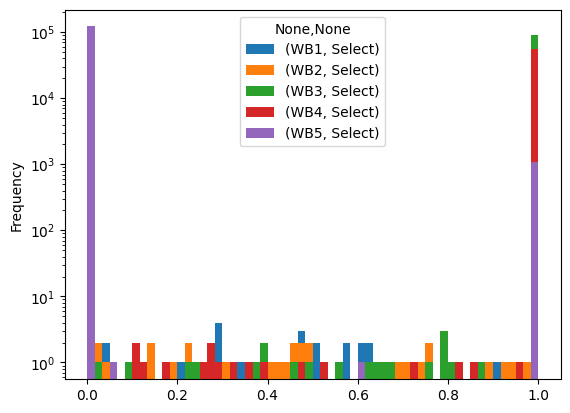

In [13]:
wb_sections = [f'WB{i}' for i in range(1,6)]
wb_select_col = [(wb, 'Select') for wb in wb_sections]

fig, ax = plt.subplots(1,1)
merged_raw[wb_select_col].plot.hist(bins=60, ax=ax)
ax.set_yscale('log')

Each waterbox can be reviewed independently to determine where an appropriate floor and ceiling threshold could be placed. In all, only 132 records are under review out of 130K.

In [14]:
merged_raw.loc[((merged_raw[wb_select_col] > 0) & (merged_raw[wb_select_col] < 1)).any(axis=1), wb_select_col]

WB1       WB2       WB3       WB4    WB5
              Select    Select    Select    Select Select
Coil_ID                                                  
6264020390  0.000000  0.000000  0.087855  0.112918    0.0
6269980010  0.000000  0.000000  1.000000  0.997537    0.0
6269980020  0.000000  0.000000  1.000000  0.006125    0.0
6270000150  0.000000  0.000000  1.000000  0.109113    0.0
6270140010  0.000000  1.000000  0.169276  0.000000    0.0
...              ...       ...       ...       ...    ...
1144970140  0.027502  0.000000  0.000000  0.000000    0.0
1144970200  0.632463  0.000000  0.000000  0.000000    0.0
1145831390  0.000000  0.000000  0.286441  1.000000    0.0
6330490410  0.000000  0.458114  1.000000  1.000000    0.0
1145910110  0.000000  0.375139  1.000000  1.000000    0.0

[125 rows x 5 columns]

Distribution of counts of partially used waterboxes.
This excludes the endpoints for visibility reasons.

Text(0.5, 0, 'Amount selected')

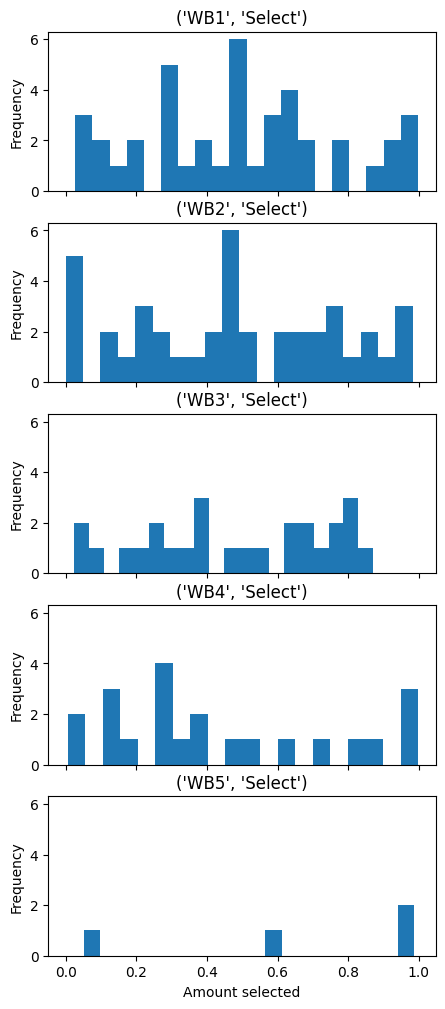

In [24]:
fig, ax = plt.subplots(5,1, sharex=True, sharey=True, figsize=(5,12))
for i, col in enumerate(wb_select_col):
    merged_raw.loc[((merged_raw[col] > 0) & (merged_raw[col] < 1)), col].plot.hist(ax=ax[i], bins=20)
    ax[i].set_title(col)
ax[4].set_xlabel('Amount selected');

There is no natural bimodal distribution for selection amounts for the five waterboxes. If it was bimodal, I would create a cutoff between "off" and "on" at the distribution minimum. To utilize these values, I'll round selection value to the closest integer. This decision may need to be revisited, and possibly drop these records all together. Counts are relatively small, so unless they contain outliers, they would be unlikely to strongly shift any evaluation. 

# Data Clean up
After rounding the selection value of the waterboxes, the value can be used as a multiplication filter to other parameters, e.g. flow and pressure. When the waterbox is off, there should be no "manipulation" of conditions due to the box. Water still flows past the sensor, so a value is read, but it does not touch the product. In preparation for further analyses, selections of zero will be set to null values. If necessary they can be filled in as zero value later, as needed. 

Additional inspection of the data is also wanrented. There continuous variables have physical characteristics which they need to meet such as flow, and pressure should be greater than 0. Temperature should be greater than 1112 F (this is the minimum value readable by the pyrometer sensor). Anything less than these values is a questionable record. 

In [61]:
process_df = merged_raw.copy()
wb_continuous_factors = ['WaterFlowTr_GPM', 'WaterFlowTr_SD', 'WaterFlowRef_%', 'WaterFlowRef_SD', 'LinePressTr_PSI']
continuous_factors = [('NTM', 'MatSpeed_MPS'), ('NTM', 'MatSpeed_SD'), ('ANTM', 'Temp'), ('ANTM', 'Temp_SD'), ('ANTM', 'Temp_RateOfChange')]
continuous_responses = [('LH', 'Temp'), ('LH', 'Temp_SD'), ('LH', 'Temp_RateOfChange')]

# Drop data which has no coil size. The blanks are an artifact of pulling realtime data.
process_df = process_df.dropna(subset=[('Coil', 'Size')])

process_df.loc[:, wb_select_col] = process_df.loc[:, wb_select_col].round(0)
for wb in wb_sections:
    process_df.loc[:, (wb, wb_continuous_factors)] = (
        process_df.loc[:,(wb, wb_continuous_factors)].multiply(process_df[(wb, 'Select')].replace(0, np.nan), axis=0)
    )

By rounding and zeroing out the "off" conditions, most of the negatives were removed. One remained, and had a "Select" value of 0.67 so it was likely nearly off too leading to a very low flow rate.

In [62]:
wb_continuous_factors_multiindex_selection = pd.MultiIndex.from_product([wb_sections, ['Select'] + wb_continuous_factors])
process_df[wb_sections].loc[(process_df[wb_continuous_factors_multiindex_selection] < 0).any(axis=1),wb_continuous_factors_multiindex_selection]

WB1                                                \
           Select WaterFlowTr_GPM WaterFlowTr_SD WaterFlowRef_%   
Coil_ID                                                           
6260970540    0.0             NaN            NaN            NaN   
1142970020    0.0             NaN            NaN            NaN   

                                              WB2                  \
           WaterFlowRef_SD LinePressTr_PSI Select WaterFlowTr_GPM   
Coil_ID                                                             
6260970540             NaN             NaN    1.0       45.809799   
1142970020             NaN             NaN    0.0             NaN   

                                          ...            WB4                 \
           WaterFlowTr_SD WaterFlowRef_%  ... WaterFlowTr_SD WaterFlowRef_%   
Coil_ID                                   ...                                 
6260970540          11.34         10.835  ...            NaN            NaN   
1142970020            NaN            NaN  ...            NaN            NaN   

                                              WB5                  \
           WaterFlowRef_SD LinePressTr_PSI Select WaterFlowTr_GPM   
Coil_ID                                                             
6260970540             NaN             NaN    0.0             NaN   
1142970020             NaN             NaN    0.0             NaN   

                                                                          
           WaterFlowTr_SD WaterFlowRef_% WaterFlowRef_SD LinePressTr_PSI  
Coil_ID                                                                   
6260970540            NaN            NaN             NaN             NaN  
1142970020            NaN            NaN             NaN             NaN  

[2 rows x 30 columns]

In [63]:
# Two records lie outside of natural limits, and are removed.
process_df = process_df.drop(['1142970020', '6260970540'])

# Distributions of Each Variable
Although descriptive statistics were used earlier, visualizing the distribution of the variables may provide some additional insights regarding the collected data. Each product size can be considered a categorical variable. There are many other upstream influences that make the products unique, so building a comprehensive model which does not separate these products may be difficult. Also there can be a bias introduced because of the number of samples for each size. 

## Number of records by size

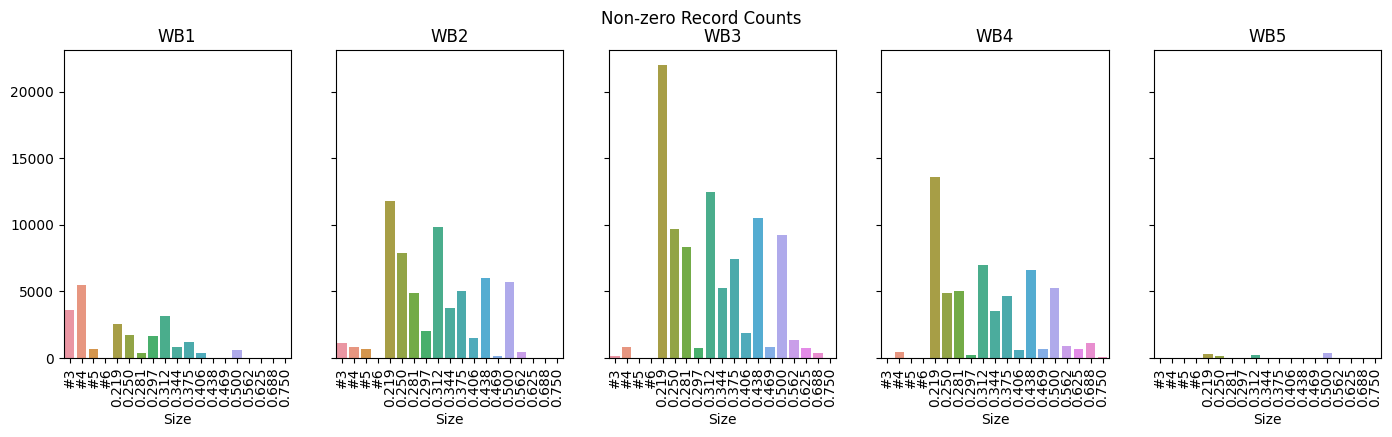

In [64]:
size_order = sorted(process_df[('Coil', 'Size')].unique())

coil_counts = (
    process_df
    .swaplevel(axis=1)
    ['Select']
    .groupby(process_df[('Coil', 'Size')]).sum()
    .rename_axis('Size')
)

fig, ax = plt.subplots(1,5, figsize=(17, 4), sharey=True)
for i, wb in enumerate(wb_sections):
    sns.barplot(data=coil_counts, x= coil_counts.index, y=wb, order=size_order, ax=ax[i])
    ax[i].set(xlabel='Size', ylabel='', title=wb)
    ax[i].set_xticklabels(size_order, rotation=90, )
    fig.suptitle('Non-zero Record Counts')


Waterboxes 2, 3 and 4 are the most utilized. Because of product mix, the smallest diameter rod is (0.219) is the most frequent. Several additional rod sizes are of similar frequency. A third tier is barely represented in the data. An evaluation needs to be done to confirm which combination of boxes were used in proportion.

## Box utilization schemes
Understand how much data exists for different combinations of waterboxes. First I define all the possible combinations of waterbox usage. Using the `select` factor for each waterbox. In a temporary data frame the true (1) values are converted to text, and then joined together into a hashable tuple. Each combination can be identified uniquely in this way. This could have also been accomplished using a byte array to identify each unique combination, because each waterbox condition is binary. This method is more legible.

In [65]:
wb_combinations = process_df.copy().sort_index(axis=1).loc[:, (slice(None), 'Select')]

for wb in wb_sections:
    col = (wb, 'Select')
    wb_combinations.loc[wb_combinations[col] == 1, col] = wb
    wb_combinations.loc[wb_combinations[col] == 0, col] = ''
    #wb_combinations.loc[wb_combinations[col].isna(), col] = ''

wb_combinations[('WB', 'Selected')] = wb_combinations.apply(lambda x: tuple(w for w in x if w != '').__repr__(), axis=1)
wb_combinations.loc[wb_combinations[wb_sections].isna().all(axis=1), ('WB', 'Selected')] = np.nan
wb_combinations[('WB', 'Counts')] = process_df.sort_index(axis=1).loc[:, (slice(None), 'Select')].sum(axis=1)
wb_combinations

WB1    WB2    WB3    WB4    WB5                     WB       
           Select Select Select Select Select               Selected Counts
Coil_ID                                                                    
6262930370    NaN    NaN    NaN    NaN    NaN                    NaN    0.0
6262930380                                                        ()    0.0
6263890050                                                        ()    0.0
6263890060                                                        ()    0.0
6263890070                                                        ()    0.0
...           ...    ...    ...    ...    ...                    ...    ...
6346160170           WB2    WB3    WB4         ('WB2', 'WB3', 'WB4')    3.0
6346160180           WB2    WB3    WB4         ('WB2', 'WB3', 'WB4')    3.0
6346160190           WB2    WB3    WB4         ('WB2', 'WB3', 'WB4')    3.0
6346160200           WB2    WB3    WB4         ('WB2', 'WB3', 'WB4')    3.0
6330490470    NaN    NaN    NaN    NaN    NaN                    NaN    0.0

[133896 rows x 7 columns]

In [66]:
wb_combinations[('WB', 'Selected')].value_counts()

('WB3', 'WB4')                  36733
('WB2', 'WB3')                  33553
('WB2', 'WB3', 'WB4')           10734
('WB1',)                         9305
('WB1', 'WB2', 'WB3')            7338
()                               7242
('WB1', 'WB2')                   5523
('WB4',)                         4412
('WB3',)                         2707
('WB2', 'WB4')                   2158
('WB2',)                         2044
('WB3', 'WB4', 'WB5')             606
('WB4', 'WB5')                    312
('WB2', 'WB3', 'WB4', 'WB5')      176
('WB1', 'WB2', 'WB4')             129
('WB1', 'WB2', 'WB3', 'WB5')        2
('WB5',)                            1
Name: (WB, Selected), dtype: int64

In [117]:
wb_combinations.join(process_df[('Coil', 'Size')]).value_counts(subset=[('Coil', 'Size'), ('WB', 'Selected')]).head(20)

(Coil, Size)  (WB, Selected)       
0.219         ('WB3', 'WB4')           11415
              ('WB2', 'WB3')            9319
#5            ()                        6161
#4            ('WB1',)                  5479
0.438         ('WB3', 'WB4')            4499
0.500         ('WB2', 'WB3')            4475
0.250         ('WB2', 'WB3')            4438
0.438         ('WB2', 'WB3')            3935
0.312         ('WB2', 'WB3')            3855
0.500         ('WB3', 'WB4')            3845
0.312         ('WB3', 'WB4')            3816
0.281         ('WB3', 'WB4')            3402
0.250         ('WB3', 'WB4')            3191
#3            ('WB1',)                  3072
0.312         ('WB1', 'WB2', 'WB3')     2988
0.281         ('WB2', 'WB3')            2860
0.375         ('WB3', 'WB4')            2435
0.219         ('WB1', 'WB2')            2389
0.375         ('WB2', 'WB3', 'WB4')     2223
0.438         ('WB2', 'WB3', 'WB4')     2099
dtype: int64

The two most prominent utilization schemes are using waterboxes 3 & 4 and waterboxes 2 & 3. This represents 57% of the data. and each is about three times more utilized than the third hightest scheme. Initial focus will be on these two schemes, with additional 

In [21]:
# Unneeded code to determine all unique combinations of waterboxes. If values need to be enumerated, then this may come in useful.
# from itertools import combinations, chain
# boxes_used = list(chain(*[combinations(wb_sections, r) for r in range(0, len(wb_sections)+1)]))
# pd.Series(boxes_used).reset_index().set_index

## Plotting Continuous Factors of Waterboxes by Size
Visual comparison of the distribution of each continuous factor may provide insights. There appear to be several outliers with regards to the standard deviation and slope values. 

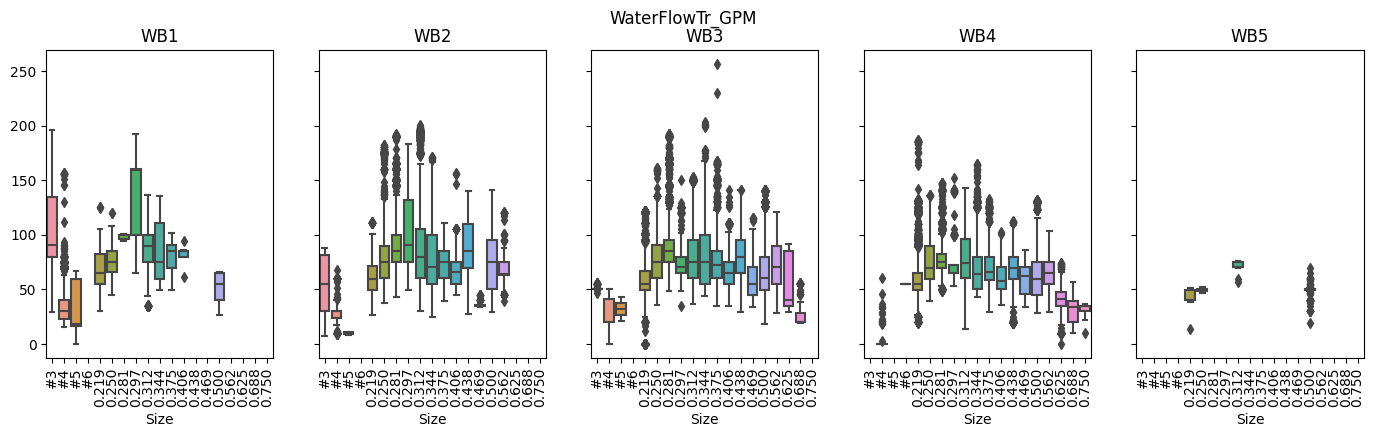

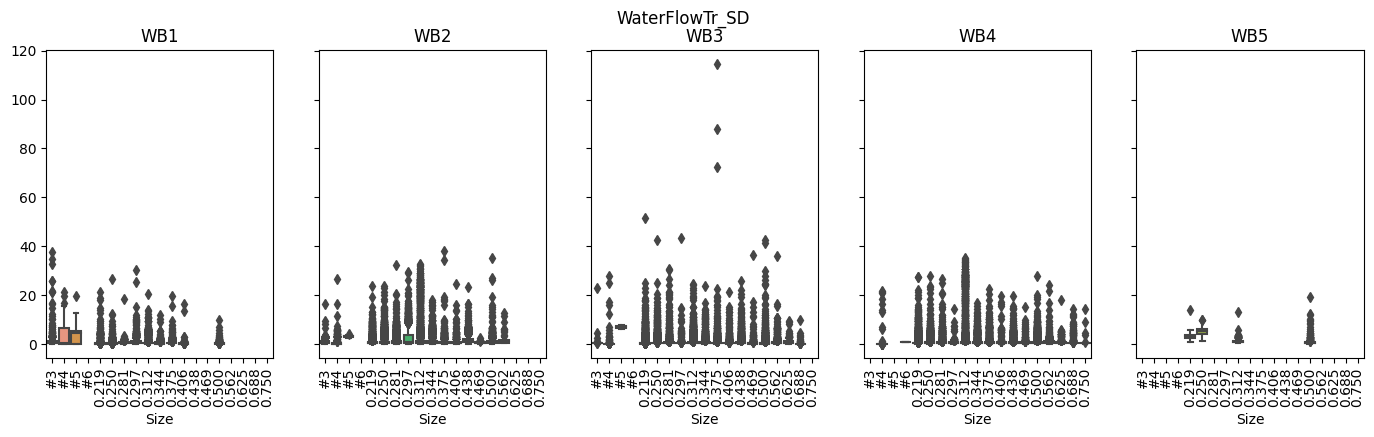

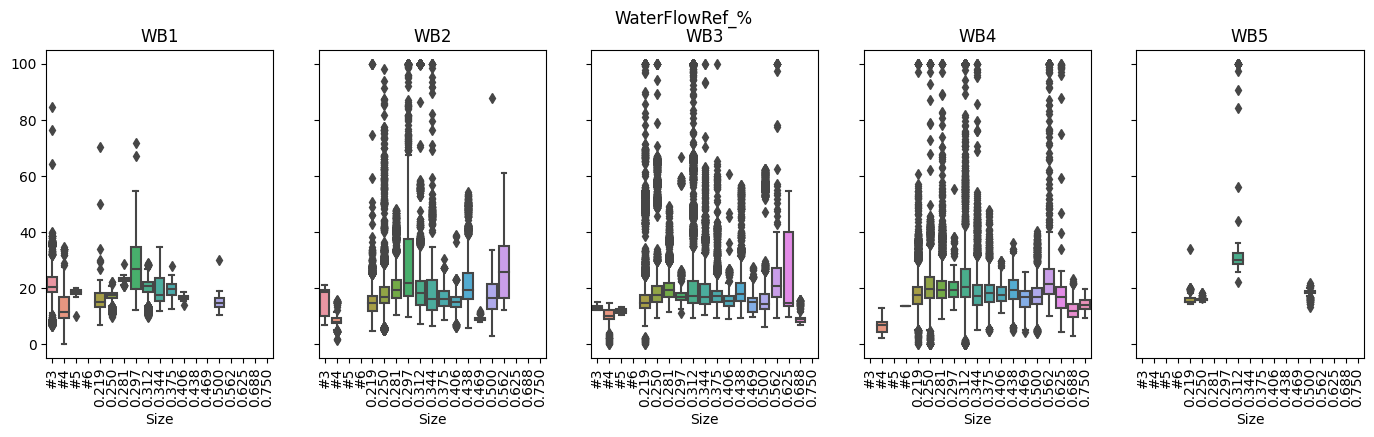

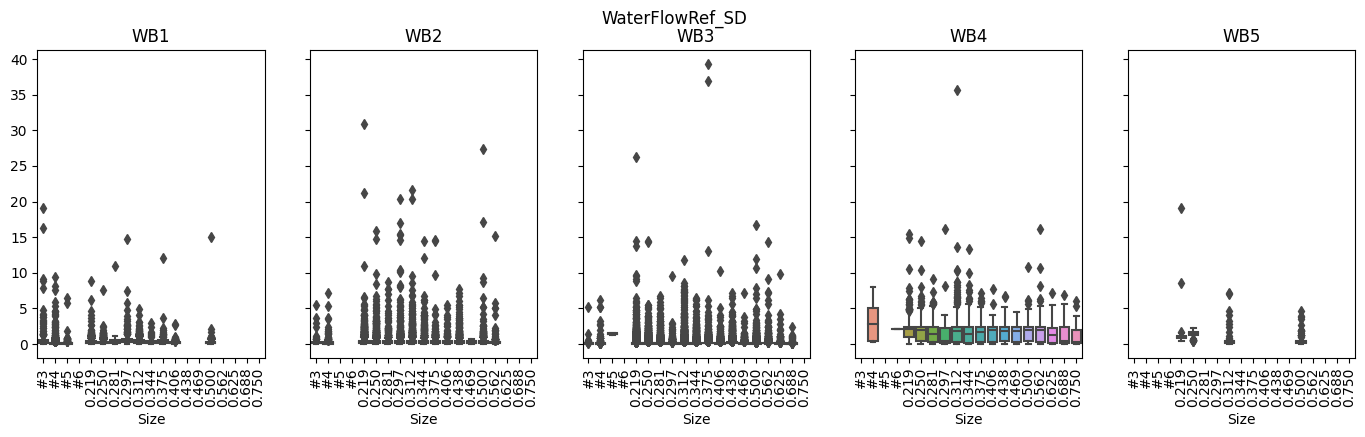

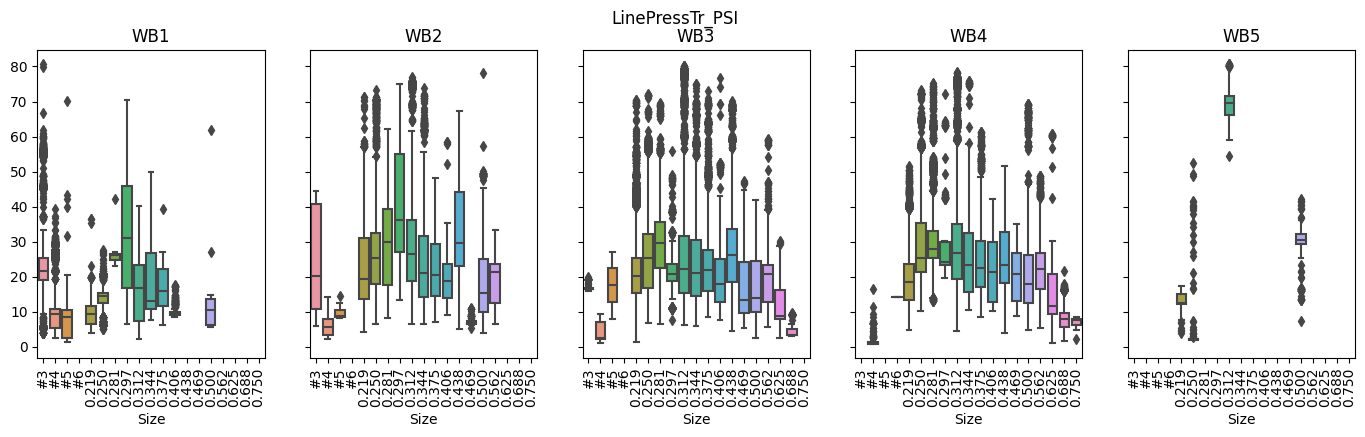

In [67]:
for factor in wb_continuous_factors:
    fig, ax = plt.subplots(1,5, figsize=(17, 4), sharey=True)
    for i, wb in enumerate(wb_sections):
        sns.boxplot(
            x=process_df[('Coil', 'Size')], 
            y=process_df[(wb, factor)].replace(0, np.nan), 
            order=size_order, 
            ax=ax[i]
        )
        ax[i].set(xlabel='Size', ylabel='', title=wb)
        ax[i].set_xticklabels(size_order, rotation=90)
        fig.suptitle(factor)


### Outlier evaluation
For size 0.325 on waterbox 3, there are three outliers in the standard deviation for the water flow actual. All three are consecutive coils, and the middle one had a full open on the control valve (which is unusual). Their production time was typical, and I find no cause to remove the data.

For size 0.325 on waterbox 3, there are two outliers in the standard deviation for the flow valve opening. They are not consecutive coils, but do occur on the same day as the previous three. Their production time was typical, and I find no cause to remove the data. Because all 5 occurred on the same day, there may have been a difficulty in obtaining good data for the day, or the boxes were very difficult to control at this time.

Two additional outliers were investigated for waterbox 2 and on outlier in waterbox 4 for flow valve opening standard deviation. Nothing unusual seems to stand out for other values. 

## Plotting Other Continuous Factors by Size
Visual comparison of the distribution of additional continuous factor may provide insights. These continuous factors describe the condition of the material prior to interacting with the water boxes. 

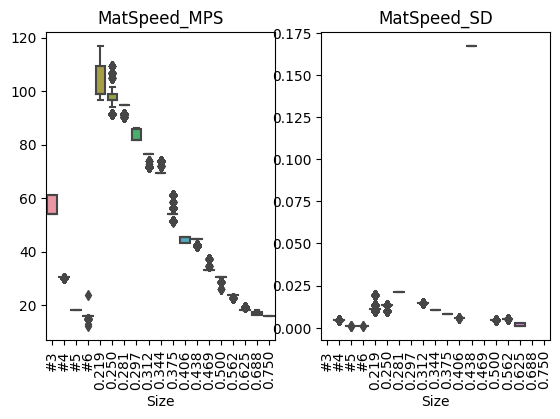

In [68]:
fig, ax = plt.subplots(1,2, figsize=(6.5, 4))
for i, factor in enumerate(continuous_factors[:2]):
    sns.boxplot(
        x=process_df[('Coil', 'Size')], 
        y=process_df[factor].replace(0, np.nan), 
        order=size_order, 
        ax=ax[i]
    )
    ax[i].set(xlabel='Size', ylabel='', title=factor[1])
    ax[i].set_xticklabels(size_order, rotation=90)
    #fig.suptitle(factor[1])

The material speed is a very stable value with high speed, and low variation.

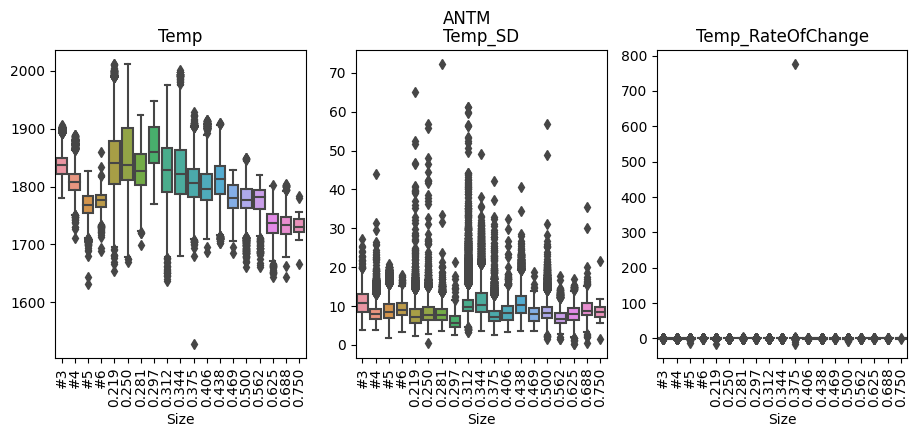

In [69]:
fig, ax = plt.subplots(1,3, figsize=(11, 4))
for i, factor in enumerate(continuous_factors[2:]):
    sns.boxplot(
        x=process_df[('Coil', 'Size')], 
        y=process_df[factor].replace(0, np.nan), 
        order=size_order, 
        ax=ax[i]
    )
    ax[i].set(xlabel='Size', ylabel='', title=factor[1])
    ax[i].set_xticklabels(size_order, rotation=90)
fig.suptitle('ANTM');

### Outlier evaluation
In the after NTM  (input) temperature, there is a noticeable low temperature input. It gains 100F during the cooling process, so I would consider this a incorrectly recorded value, and will drop this subset of data.

There is one standout point in the temperature slope for the After NTM data. Evaluating the point, it was 47 seconds long (short) and had a high slope with a zero standard deviation (a contradiction). I do not believe that these are accurate values, and will drop this subset of data. 

Other collected points appear to be reasonable. I looked at conditions where the standard deviation was 0.0, yielding 16 results. 13 had no recorded value, the other three had very small slopes, so they are likely legitimate. 

The condition where the final temperature was greater than the initial temperature was also evaluated. All coils (except for the one noted previously) were coils which received no cooling, and temperature increase is possible as the hotter core can reheat the surface over time. No addition removals are required.



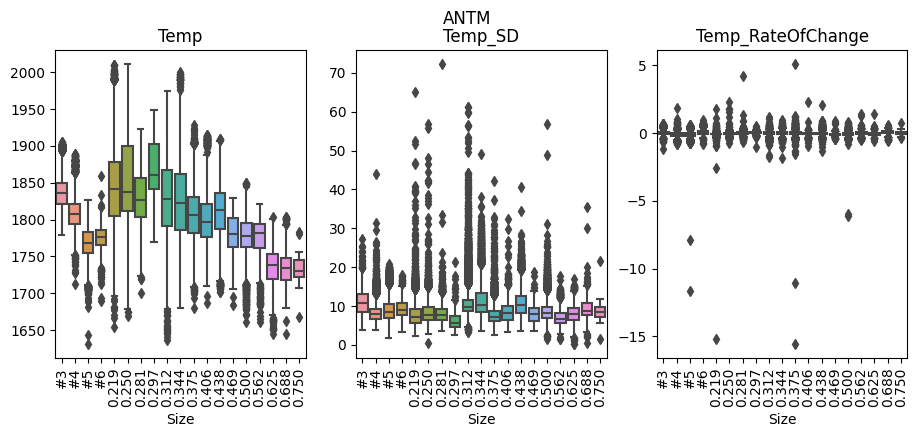

In [70]:
# Removal of outlier data.
process_df.loc[process_df[('ANTM', 'Temp_RateOfChange')] > 25, 'ANTM'] = np.nan
process_df.loc[process_df[('ANTM', 'Temp')] < 1600, 'ANTM'] = np.nan

# Replot
fig, ax = plt.subplots(1,3, figsize=(11, 4))
for i, factor in enumerate(continuous_factors[2:]):
    sns.boxplot(
        x=process_df[('Coil', 'Size')], 
        y=process_df[factor].replace(0, np.nan), 
        order=size_order, 
        ax=ax[i]
    )
    ax[i].set(xlabel='Size', ylabel='', title=factor[1])
    ax[i].set_xticklabels(size_order, rotation=90)
fig.suptitle('ANTM');

## Plotting Continuous Responses by Size
Visual comparison of the distribution of each response may provide insights. 

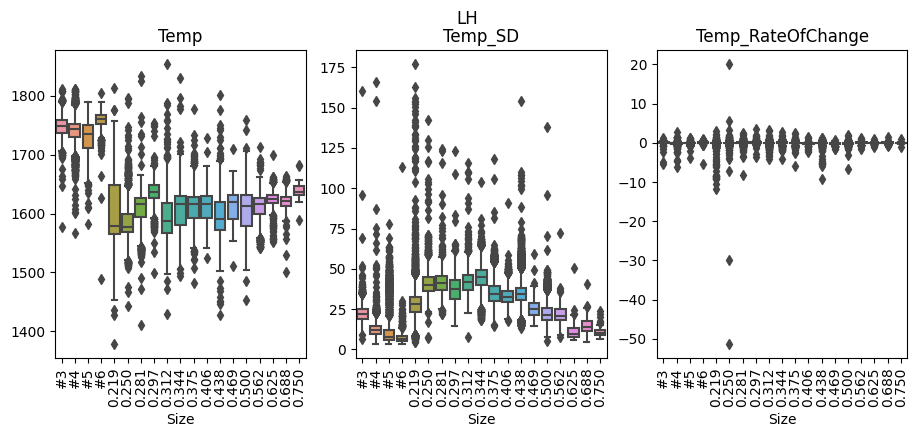

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
for i, factor in enumerate(continuous_responses):
    sns.boxplot(
        x=process_df[('Coil', 'Size')], 
        y=process_df[factor].replace(0, np.nan), 
        order=size_order, 
        ax=ax[i]
    )
    ax[i].set(xlabel='Size', ylabel='', title=factor[1])
    ax[i].set_xticklabels(size_order, rotation=90)
    
fig.suptitle('LH');

### Outlier evaluation
In the Laying head (final) temperature, there are two is a noticeable low temperature slopes, and one high. There isn't an indication that this value should be dropped, but no input temperature was recorded, so they may be dropped during model building. 

No other data points stand out sufficiently to warrant investigation. 


# Correlations

Selection of color map to support correlations. Lighter colors are little correlation, dark colors are highest correlation. Red negative, blue positive. Does not have on/off binary signals included, only continuous.

Have to think about combination correlations, since it is a cumulative (non linear) usage of water.

In [51]:
# sizes: size_order
# boxes
import itertools
wb_continuous_factors_idx = list(itertools.product(wb_sections, wb_continuous_factors))
correlation_factors = wb_continuous_factors_idx + continuous_factors + continuous_responses
len(correlation_factors)

33

<AxesSubplot: xlabel='None-None', ylabel='None-None'>

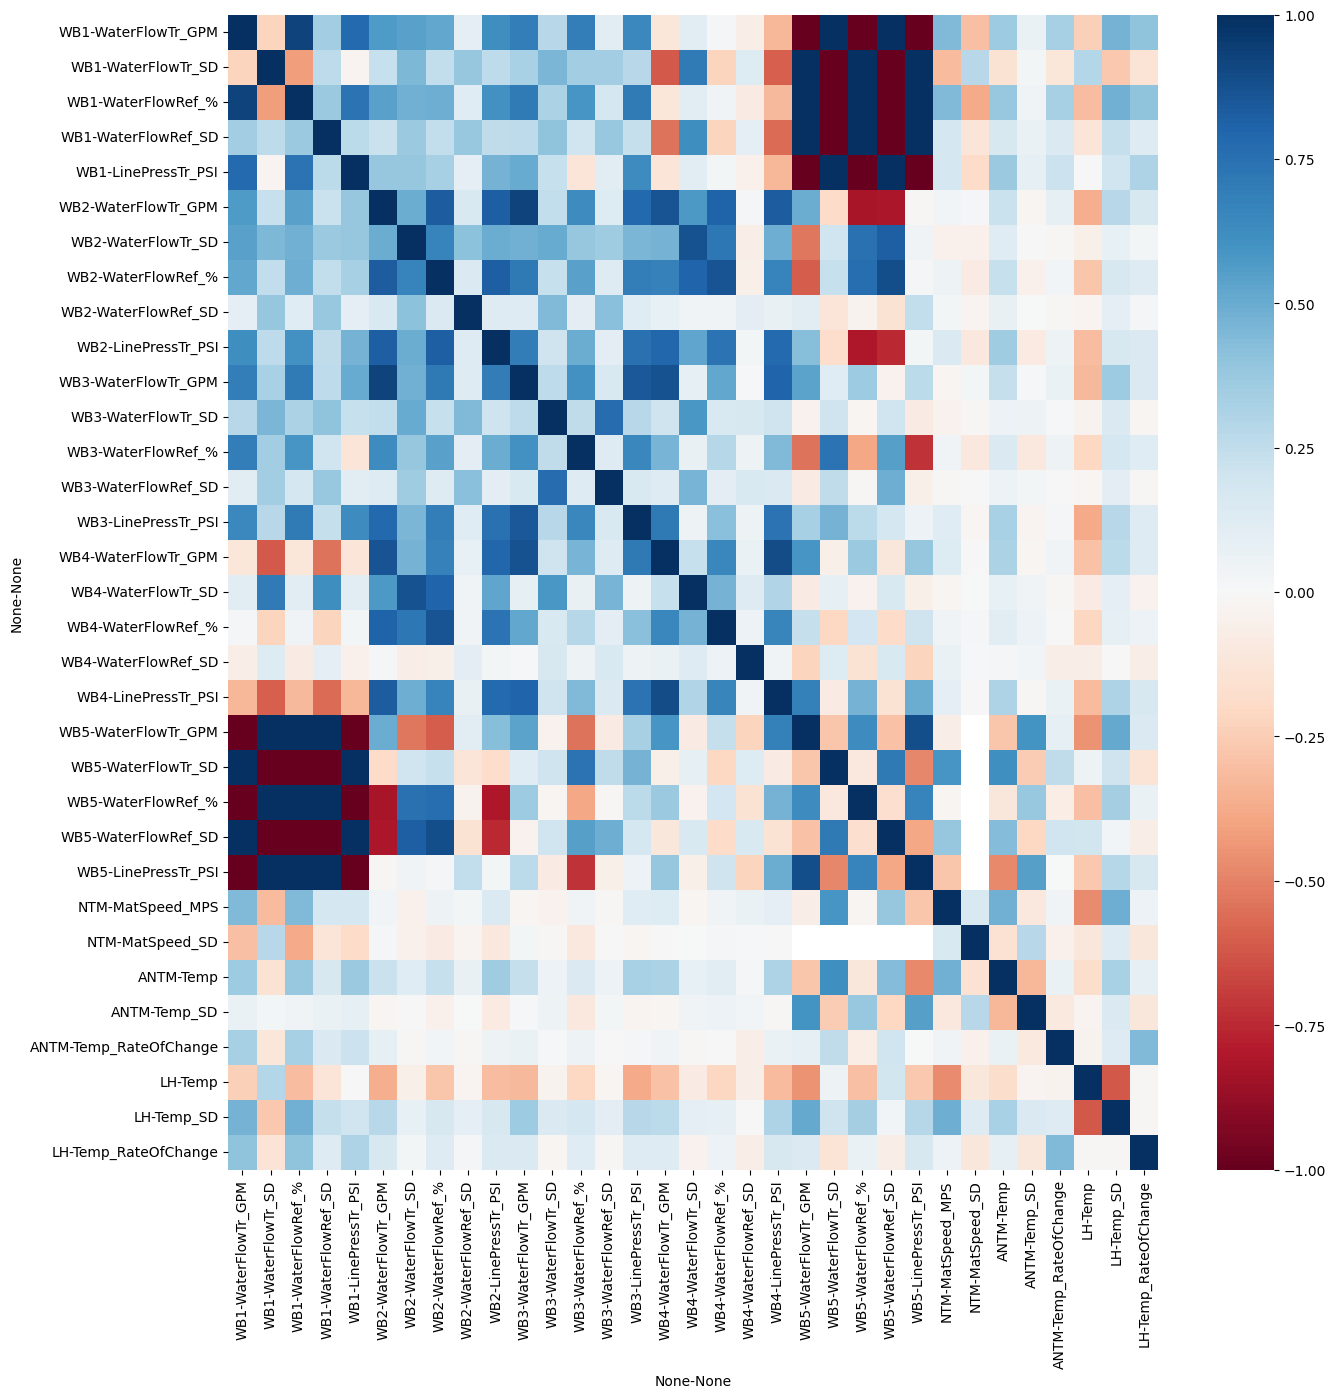

In [73]:
fig, ax = plt.subplots(1,1, figsize= (15, 15))
sns.heatmap(process_df[correlation_factors].corr(), ax=ax, cmap='RdBu')

Within each waterbox, signals between flow reference opening and pressures are positively correlated. This makes physical sense, with a given piping system, pressure has to rise to push more water into the system, and the controlling valve allows the additional flow to increase. 

Standard deviation is weakly positively correlated to the other signals within a waterbox for four of the waterboxes. From a process control standpoint a correlation of zero is most desired, which would indicate that the variation in the waterbox control parameters have a natural variation which is not correlated to the setting. In this case as pressure flow and reference position increase, the variation also increases. 

I will explore covariance between flow reference position and pressure. Splitting out by size may also be of interest. 
Between the controllable signals for the waterboxes, they are weakly correlated to between each other. The most notable exception is waterbox 1 to waterbox 4 and 5. Very strong correlation between box 1 and 5 can be explained by having only two data points, making a perfect correlation. The correlation between waterbox 1 and 4 contains only 129 data points, so I won't be pulling any strong inferences. 

The input of material speed does not appear to be strongly correlated to any waterbox setting.

Of most interest is the correlation between inputs and the response temperature variable. For waterbox parameters, there is a negative correlation between the value and the temperature, which is understandable. As more cooling water is added to the system, the output temperature should decrease. Standard deviations are weakly correlated to the LH temperature. The standard deviation of the laying heat to the temperature is strongly negatively correlated, resulting in the standard deviation being positively correlated to the other waterbox control values. As they generally increase, the variation within a coil also increase. 

## Correlations to total water used
Reviewing the correlations between the water for and individual box and the resulting temperature did not yield very high correlations. The contribution to cooling for each waterbox is not strictly additive. One box will make more of a contribution to cooling than another box, even with the same settings. Setting that nuance aside, assume they the split is similar enough, I want to determine if there is a stronger correlation to the total water used and the final LH temperature than looking at a box individually. 


In [98]:
flow_columns = list(itertools.product(wb_sections, ['WaterFlowTr_GPM']))
process_df[('WB', 'TotalFlow_GPM')] = process_df[flow_columns].sum(axis=1, min_count=1)
process_df[[('WB', 'TotalFlow_GPM'), ('LH', 'Temp')] + flow_columns].corr()[('LH', 'Temp')]


WB   TotalFlow_GPM     -0.548322
LH   Temp               1.000000
WB1  WaterFlowTr_GPM   -0.238473
WB2  WaterFlowTr_GPM   -0.366462
WB3  WaterFlowTr_GPM   -0.324660
WB4  WaterFlowTr_GPM   -0.295268
WB5  WaterFlowTr_GPM   -0.449734
Name: (LH, Temp), dtype: float64

Correlation is stronger between the total water used and the final temperature, compared to individual boxes.

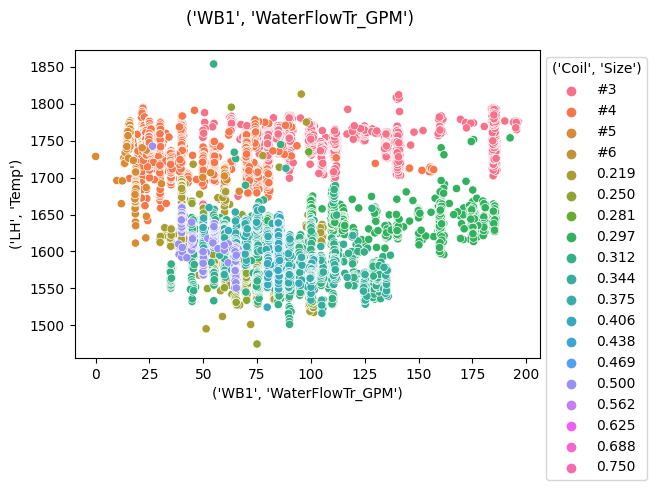

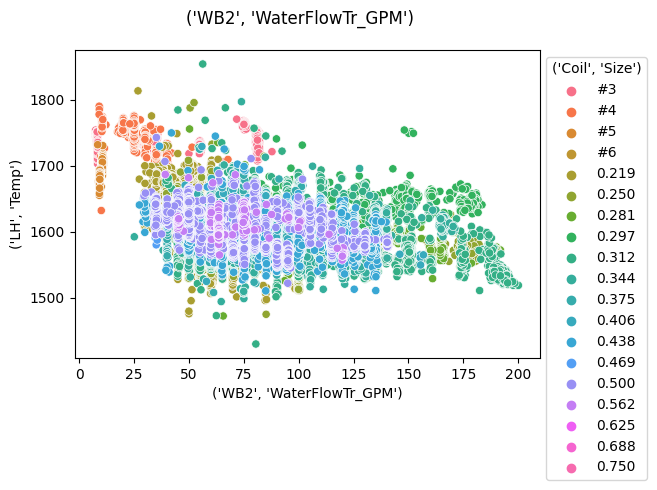

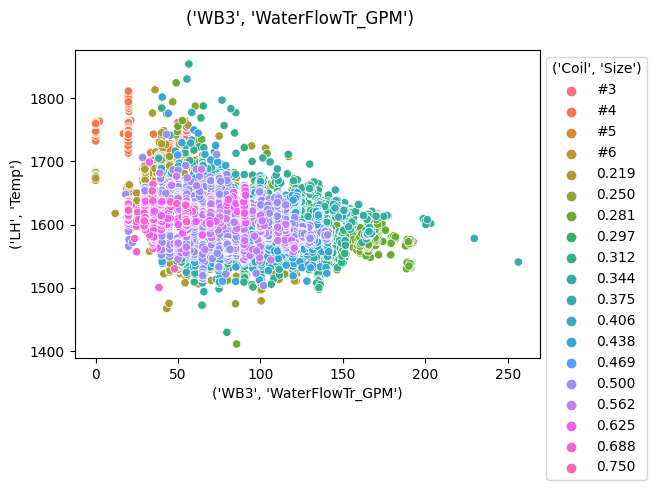

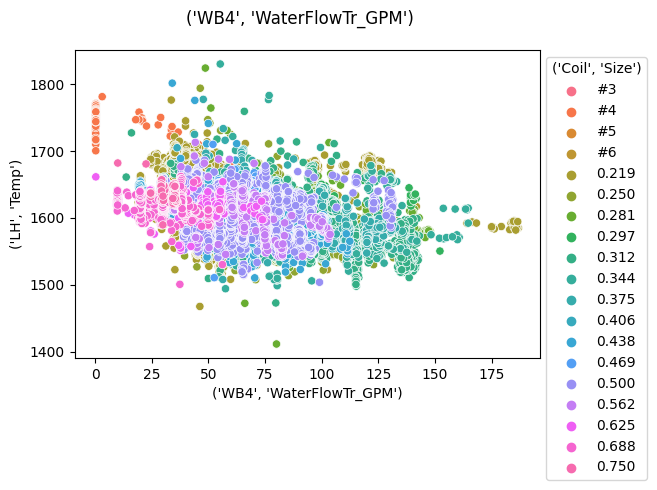

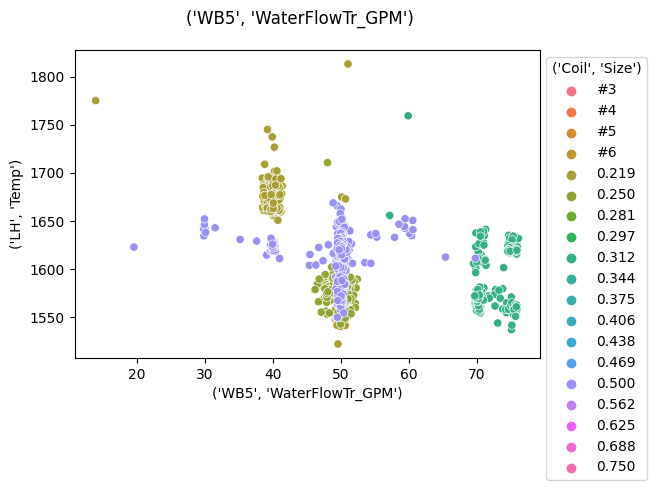

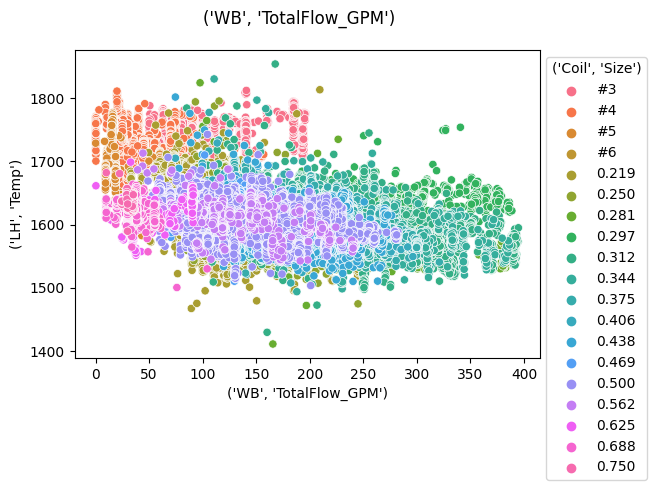

In [100]:
for wb in flow_columns + [('WB', 'TotalFlow_GPM')]:
    fig, ax = plt.subplots(1,1, figsize=(6,4))
    sns.scatterplot(data=process_df.sort_values(('Coil', 'Size')), x=wb, y=('LH', 'Temp'), hue=('Coil', 'Size'), ax=ax)
    fig.suptitle(wb)
    sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

Split out rebar and high carbon. Appears to be ustilized as two distinctive popuations. (SVM for fun but doesn't answer the business case.)


## Scatter Plot Comparison of Continuous Variables by Size
As previously stated, a review of the relationship between flow, reference position and pressure looking for collinearity by size is important.
Standard deviations, although and interesting descriptive statistic does not correlate highly. To limit the number of comparisons, these parameter groups will be dropped.
Pair plot

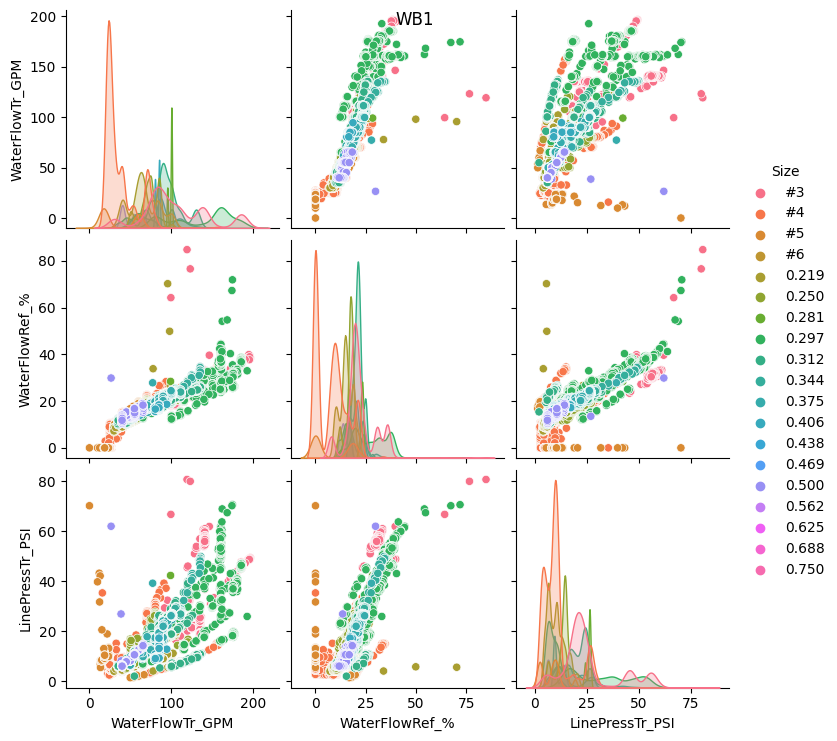

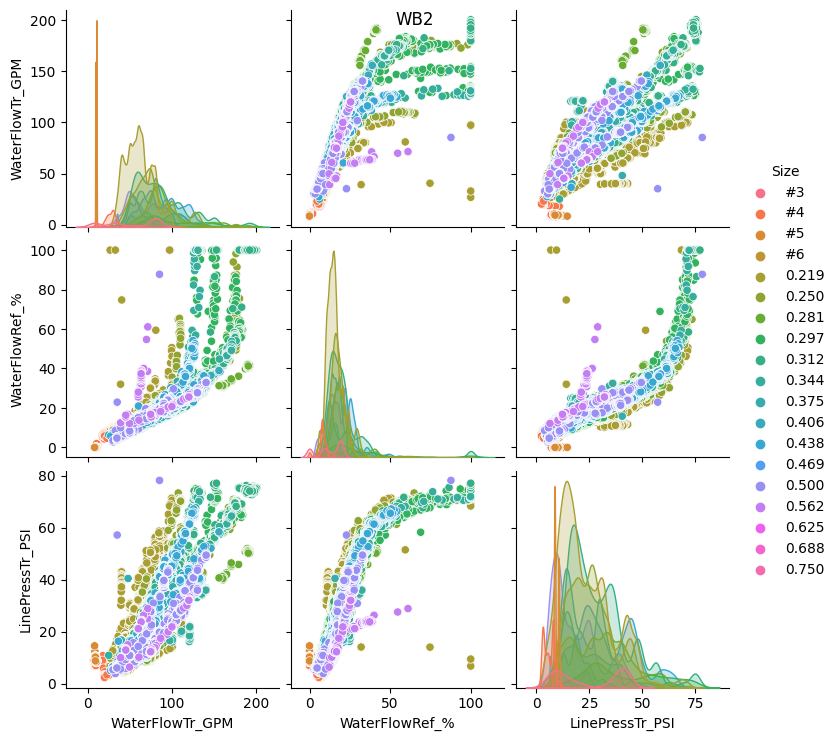

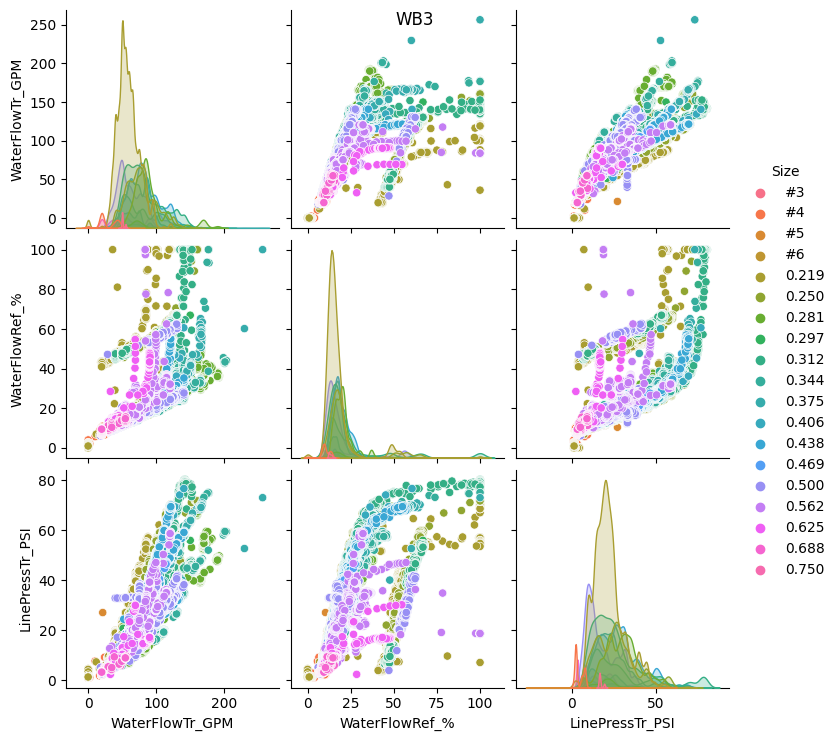

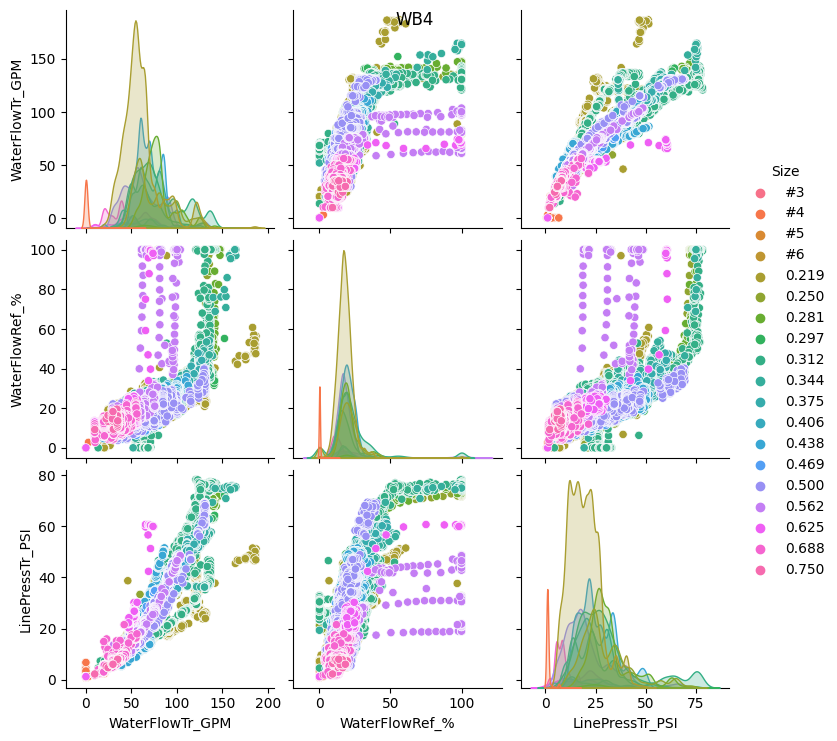

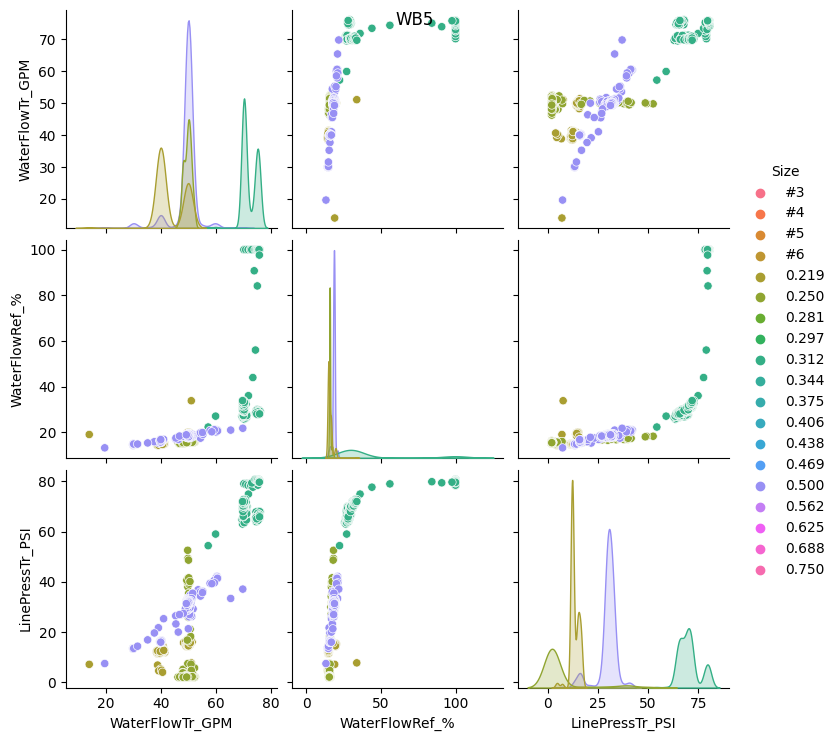

In [141]:
signals = [signal for signal in wb_continuous_factors if  not signal.endswith('SD')]
for wb in wb_sections:
    #fig, ax = plt.subplots(1,1)
    g = sns.pairplot(
        data=process_df[wb][signals].join(process_df['Coil']['Size']).sort_values('Size'),
        hue='Size',)
    g.fig.suptitle(wb)

Flow rate to water pressure appears to be most linear of any comparisons within a box, for all boxes. Within a given size, there is a lot less scatter than the plot as a whole, and at different slopes. I believe that there is enough of a process shift to warrant looking at different models between sizes, instead of attempting to make an all inclusive model.

Comparing water flow and pressure to the valve position, they both demonstrate a sigmoidal curve, which is expected for the type of valve used. 

Looking at waterbox 3 and 4 the larger diameter products have multiple curves for the same diameter. At a given valve opening, they could have multiple pressures and flow rates. For some products, two different nozzle diameters can be used. These branches may be a direct result of using different nozzle types. 

### General Observations

The four sizes starting with a pound (#3, #4, #5, #6) are deformed rebar, and made with a very high finishing temperature, which minimizes the amount of water used (many times it is no water). All of the other sizes have a smooth and round cross section, and should behave similarly.

The amount of data present for waterbox 5 is significantly lower than the other waterboxes, and has very inconsistent trending. The other boxes have similar curvature for each comparison. I will exclude this set of features and records from model selection. 

The valve position on waterbox 3 appears to have two populations of data. One follows a similar curve for all sizes. A smaller population appears to be parallel in curvature, but offset. I suspect this shift to be a=a time related phenomena such as a calibration or broken equipment. This phenomena isn't present in any other waterbox, adding to the suspicion. Plotting this time series is below.


Coil                Time            WB3
             Size              Rolled WaterFlowRef_%
Coil_ID                                             
6292540180  0.219 2022-06-20 22:01:43      81.063797
6292540190  0.219 2022-06-20 22:10:09     100.000000
6324190020  0.219 2022-08-19 15:14:34      56.932201
6324190030  0.219 2022-08-19 15:17:07      71.588898
6324190040  0.219 2022-08-19 15:19:40      85.527496
...           ...                 ...            ...
6325010520  0.219 2022-09-01 03:48:35     100.000000
6325010530  0.219 2022-09-01 03:50:35     100.000000
6325010540  0.219 2022-09-01 03:52:35     100.000000
6324980010  0.219 2022-09-01 04:12:12      61.278599
6333850170  0.219 2022-12-05 22:43:00      96.743698

[61 rows x 3 columns]

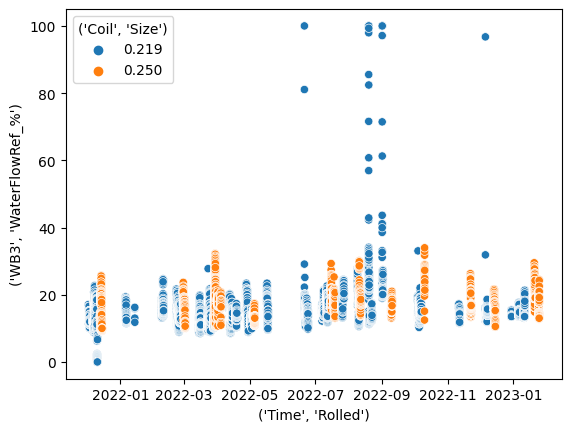

In [165]:
sns.scatterplot(
    data=(
        process_df
        .loc[
            process_df[('Coil', 'Size')].isin(['0.219', '0.250']), 
            [('Coil', 'Size'), ('Time', 'Rolled'), ('WB3', 'WaterFlowRef_%')]
        ]), 
        x=('Time', 'Rolled'), 
        y=('WB3', 'WaterFlowRef_%'), 
        hue=('Coil', 'Size')
)

(
    process_df
    .loc[
        process_df[('Coil', 'Size')].isin(['0.219', '0.250']) &
        (process_df[('WB3', 'WaterFlowRef_%')] > 45),
        [('Coil', 'Size'), ('Time', 'Rolled'), ('WB3', 'WaterFlowRef_%')]
    ]
)

The spike of the reference valve between June 1 and June 12 is very unusual. Further investigating the logs of the mill, there was a note that water flow was low (6am), starting at the same time. I believe that the sensor or valve went bad, and was giving incorrect values. Operators had to open the valve to achieve the same water flow. I will exclude this one signal over this time period from the model, as it isn't representative of typical processing. It is 2300 records, so not insignificant. The apparent outliers in the fall, I cannot exclude because it does not look like a process shift. 

In [164]:
# Excluding time period for WB3 plot
process_df.loc[
    process_df[('Coil', 'Size')].isin(['0.219', '0.250']) &
    (process_df[('Time', 'Rolled')] > '2022-06-01 06:00:00') &
    (process_df[('Time', 'Rolled')] < '2022-06-13 09:30:00')
    , 
    ('WB3', 'WaterFlowRef_%')
] = np.nan

Redisplaying the pair plots and incorproating the  with the notes from earlier

* 

In [ ]:
#Need to exclude wb5 using columns

# Factor reduction
* Remove conditions with waterbox 5
* limit to smallest 3 round sizes which use the same nozzle size
* Removal of standard deviation and slope

In [240]:
# Removal of conditions with Wb5
non_wb5_combos = [combo for combo in wb_combinations[('WB', 'Selected')].unique() if 'WB5' not in str(combo)]

# Removal of larger nozzle sizes, by reducing which rods to inspect
size_combos = ['0.219', '0.250', '0.281']

wb_combo_cols = list(itertools.product(wb_sections[0:4], [signal for signal in wb_continuous_factors if not signal.endswith('SD')]))

# Reduction of continuous factors
factor_cols = [(section, signal) for section, signal in continuous_factors + continuous_responses if not (signal.endswith('SD') or signal.endswith('RateOfChange'))]
factor_cols += [('Time', 'Rolled'), ('Coil', 'Size'), ('WB', 'Selected'), ('WB', 'TotalFlow_GPM')]

model_df = (
    process_df
    .join(wb_combinations[('WB', 'Selected')], how='left')
    .loc[
        wb_combinations[('WB', 'Selected')].isin(non_wb5_combos) &
        process_df[('Coil', 'Size')].isin(size_combos) &
        process_df[('LH', 'Temp')].notna()
        , 
        factor_cols + wb_combo_cols
    ]
    .sort_values(('Time', 'Rolled'))
)

# Rename the columns
model_df.columns = pd.MultiIndex.from_tuples([(
    section.replace('ANTM', 'NTM'), # Correct similarity in temp names
    signal.replace(
        'Temp', 
        'PreTemp' if section=='ANTM' else 'PostTemp')
        ) # Make tuples
        for section, signal in model_df.columns
    ])

model_df.head()

NTM                        LH                Time   Coil  \
           MatSpeed_MPS      PreTemp     PostTemp              Rolled   Size   
Coil_ID                                                                        
6264020400    99.059998  1881.640015  1631.630005 2021-12-02 08:26:28  0.219   
6265990010    99.059998  1867.910034  1556.670044 2021-12-02 08:40:24  0.219   
6265990020    99.059998  1877.810059  1563.250000 2021-12-02 08:50:54  0.219   
6265990050    99.059998  1879.589966  1564.819946 2021-12-02 09:00:02  0.219   
6265990060    99.059998  1879.479980  1563.859985 2021-12-02 09:02:11  0.219   

                        WB                           WB1                 \
                  Selected TotalFlow_GPM WaterFlowTr_GPM WaterFlowRef_%   
Coil_ID                                                                   
6264020400  ('WB3', 'WB4')    102.094498             NaN            NaN   
6265990010  ('WB3', 'WB4')    141.027702             NaN            NaN   
6265990020  ('WB3', 'WB4')    139.982201             NaN            NaN   
6265990050  ('WB3', 'WB4')    139.920097             NaN            NaN   
6265990060  ('WB3', 'WB4')    139.922401             NaN            NaN   

                                       WB2                                 \
           LinePressTr_PSI WaterFlowTr_GPM WaterFlowRef_% LinePressTr_PSI   
Coil_ID                                                                     
6264020400             NaN             NaN            NaN             NaN   
6265990010             NaN             NaN            NaN             NaN   
6265990020             NaN             NaN            NaN             NaN   
6265990050             NaN             NaN            NaN             NaN   
6265990060             NaN             NaN            NaN             NaN   

                       WB3                                            WB4  \
           WaterFlowTr_GPM WaterFlowRef_% LinePressTr_PSI WaterFlowTr_GPM   
Coil_ID                                                                     
6264020400       50.699799      13.711900       16.504200       51.394699   
6265990010       70.863800      15.886500       21.215500       70.163902   
6265990020       69.785103      15.730800       20.941401       70.197098   
6265990050       69.969597      16.817600       21.063101       69.950500   
6265990060       70.000900      16.805599       21.057400       69.921501   

                                           
           WaterFlowRef_% LinePressTr_PSI  
Coil_ID                                    
6264020400      19.895399         20.5196  
6265990010      23.552700         27.1045  
6265990020      20.197399         26.9214  
6265990050      22.054300         27.0793  
6265990060      22.687500         27.0805

In [241]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43940 entries, 6264020400 to 1145811210
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   (NTM, MatSpeed_MPS)     43058 non-null  float64       
 1   (NTM, PreTemp)          42955 non-null  float64       
 2   (LH, PostTemp)          43940 non-null  float64       
 3   (Time, Rolled)          43940 non-null  datetime64[ns]
 4   (Coil, Size)            43940 non-null  object        
 5   (WB, Selected)          43505 non-null  object        
 6   (WB, TotalFlow_GPM)     43505 non-null  float64       
 7   (WB1, WaterFlowTr_GPM)  4001 non-null   float64       
 8   (WB1, WaterFlowRef_%)   4001 non-null   float64       
 9   (WB1, LinePressTr_PSI)  4001 non-null   float64       
 10  (WB2, WaterFlowTr_GPM)  23138 non-null  float64       
 11  (WB2, WaterFlowRef_%)   23138 non-null  float64       
 12  (WB2, LinePressTr_PSI)  23138 non-nul

EDA review, to confirm nothing unexpected.

<AxesSubplot: xlabel='None-None', ylabel='None-None'>

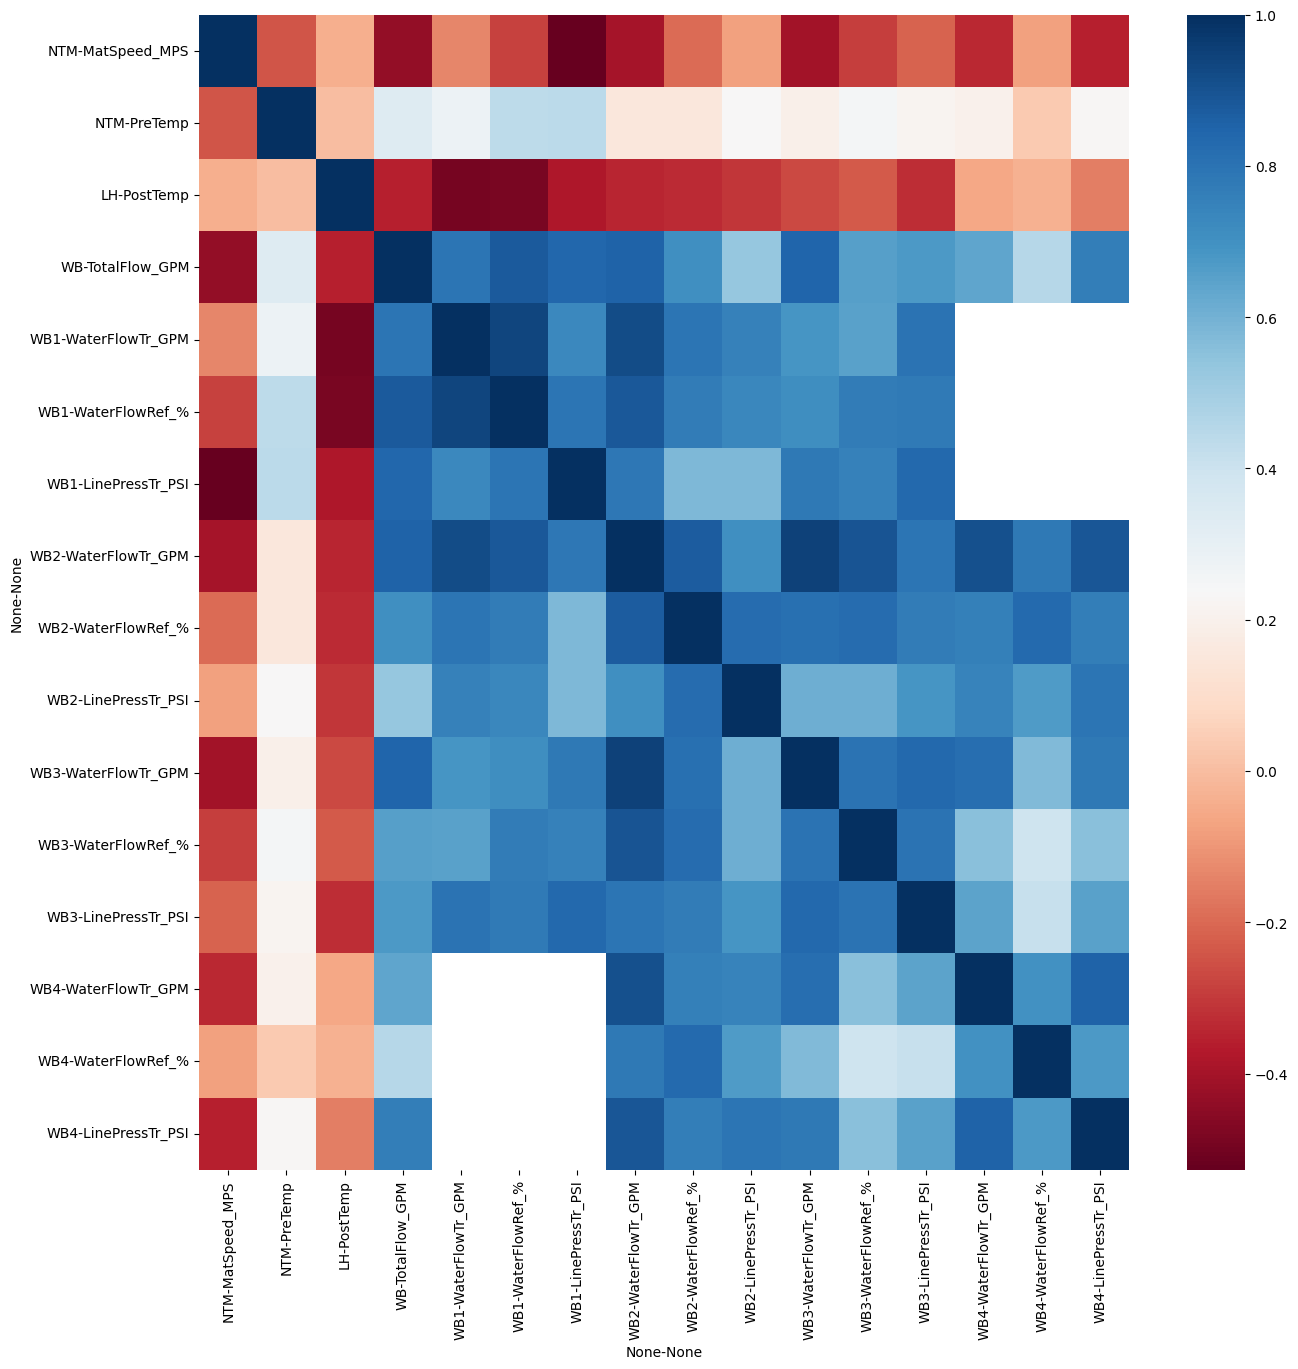

In [242]:
fig, ax = plt.subplots(1,1, figsize= (15, 15))
sns.heatmap(model_df.corr(numeric_only=True), ax=ax, cmap='RdBu')

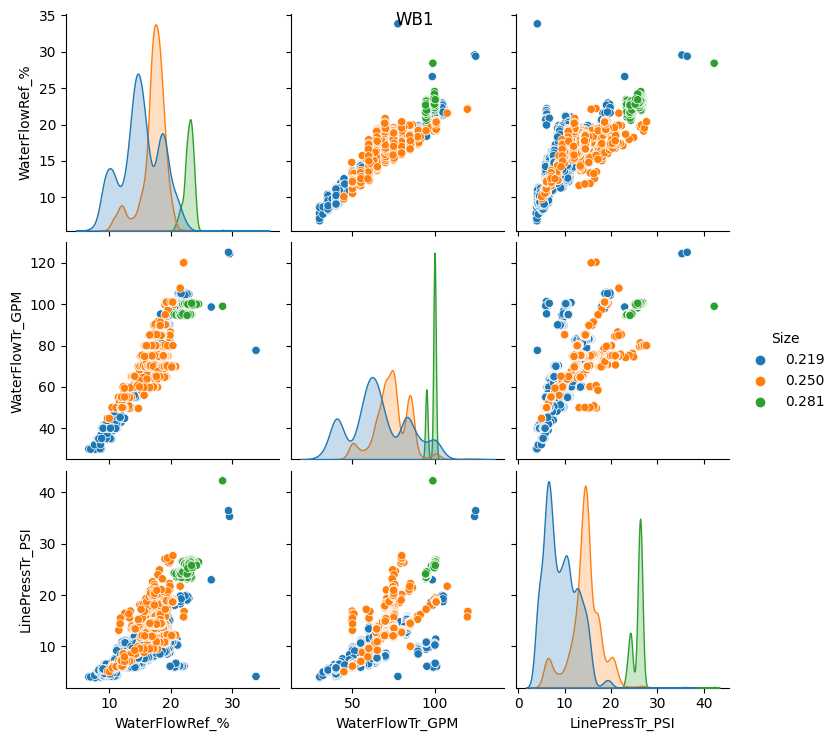

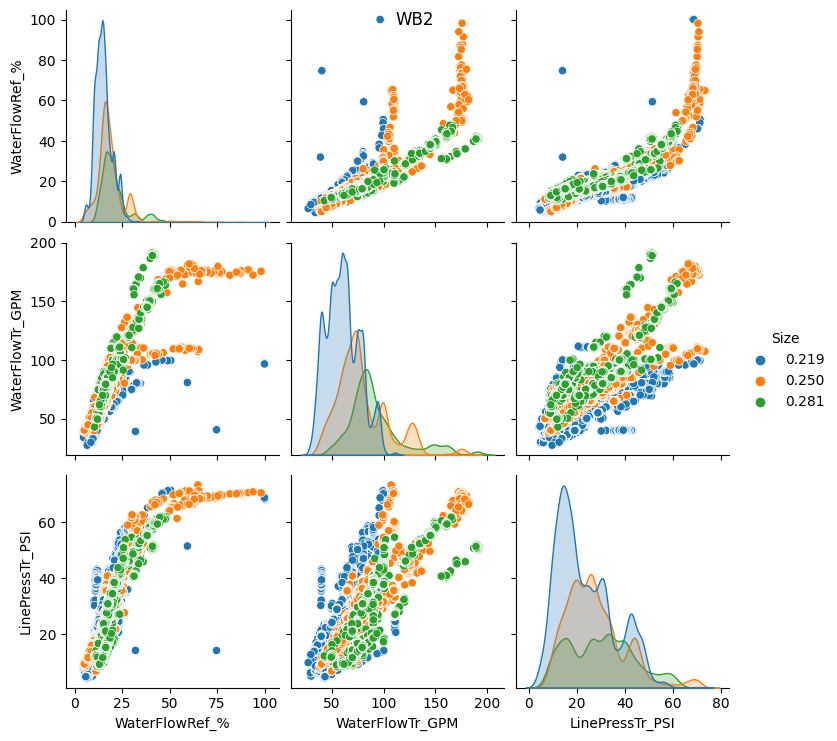

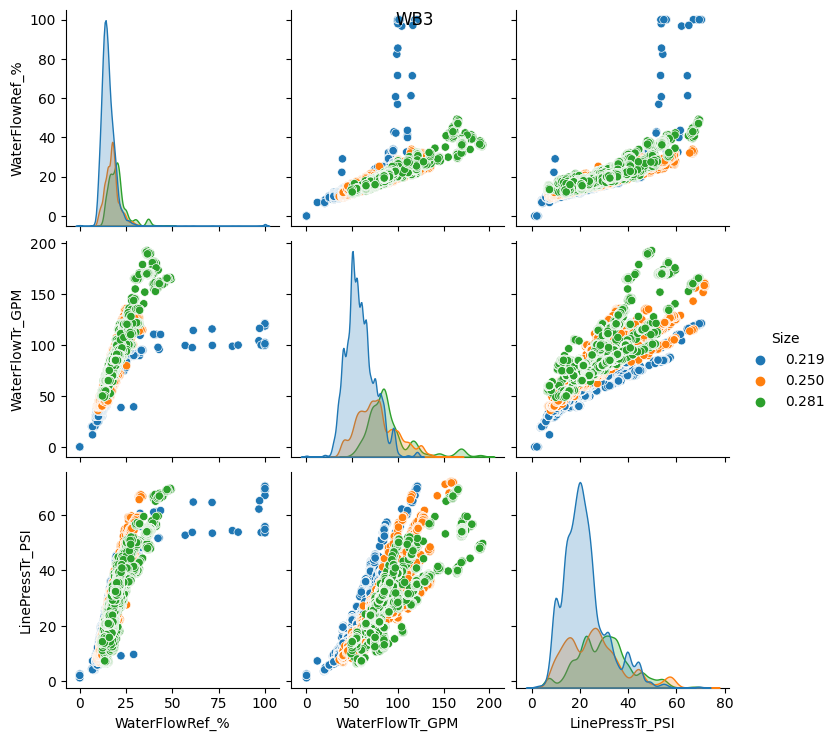

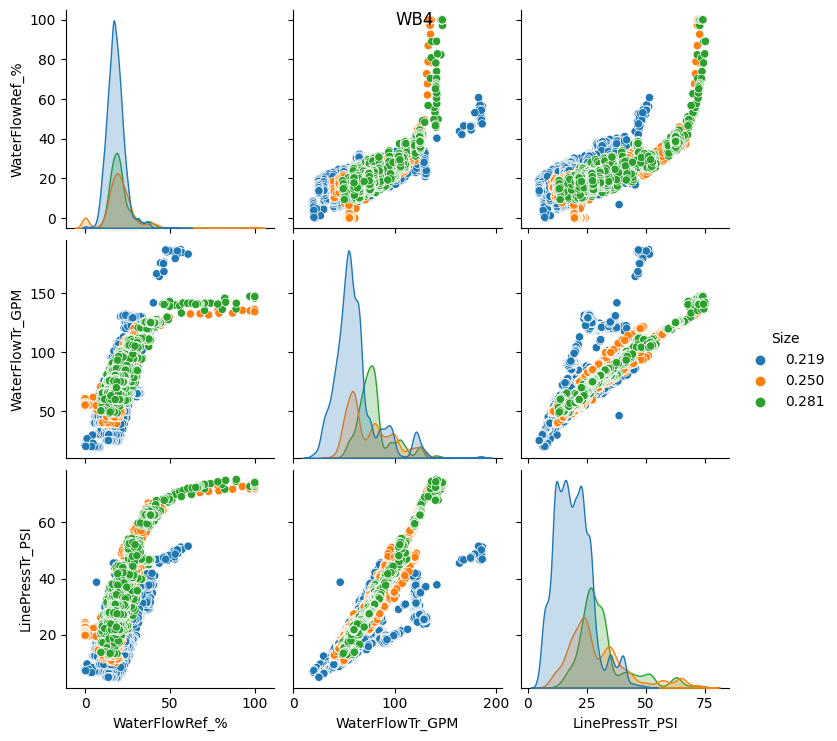

In [219]:
for wb in wb_sections[:4]:
    g = sns.pairplot(
        data=(
            model_df[
                [
                    (wb, 'WaterFlowRef_%'),
                    (wb, 'WaterFlowTr_GPM'),
                    (wb, 'LinePressTr_PSI'),
                    ('Coil', 'Size')
                ]
            ]
            .droplevel(0, axis=1)
            .sort_values('Size')
        ),
        hue='Size',)
    g.fig.suptitle(wb)


Text(0.5, 0.98, 'Remaining factors')

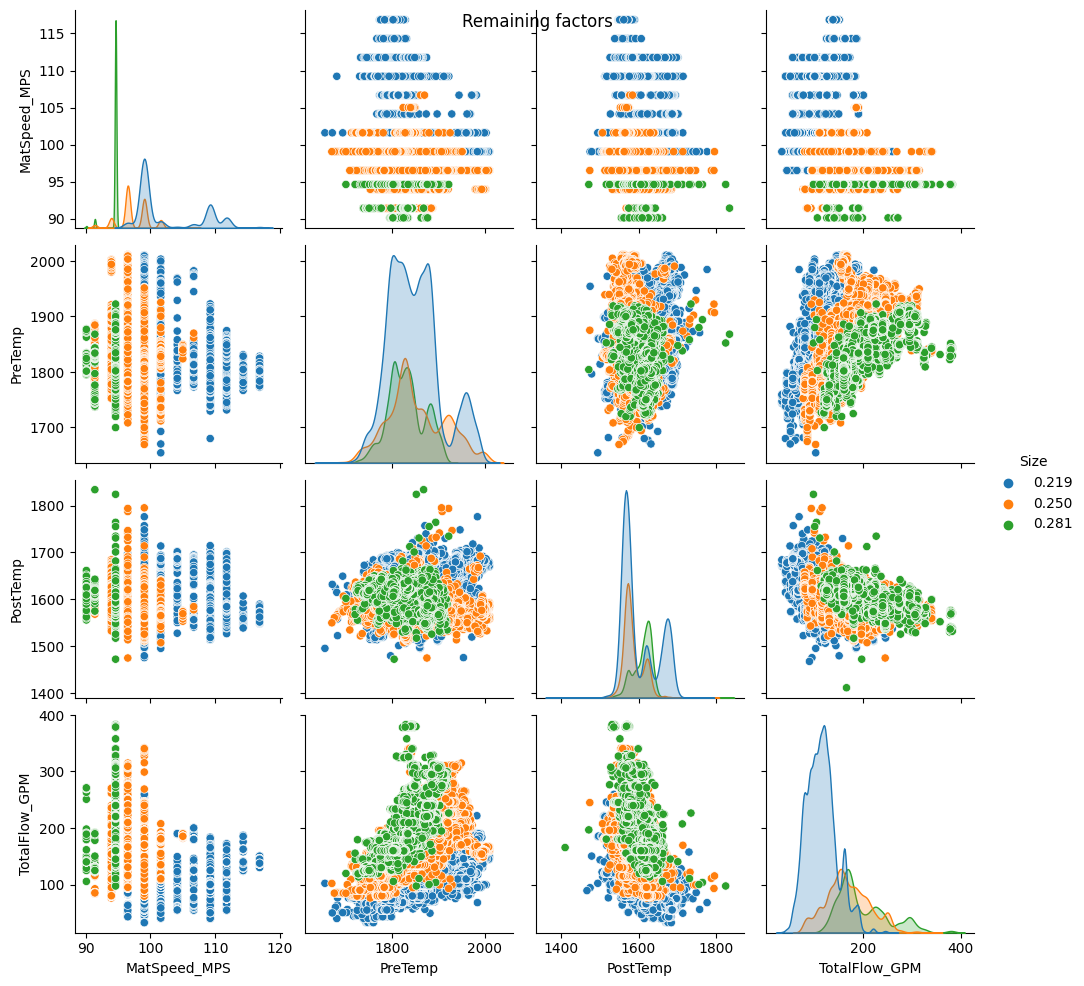

In [243]:
g = sns.pairplot(
    data=(
        model_df[
            [
                ('NTM', 'MatSpeed_MPS'),
                ('NTM', 'PreTemp'),
                ('LH', 'PostTemp'),
                ('Coil', 'Size'),
                ('WB', 'TotalFlow_GPM'),
            ]
        ].rename(columns={
            ('ANTM', 'Temp'): ('ANTM', 'PreTemp'),
            ('LH', 'Temp'): ('LH', 'PostTemp')
        })
        .droplevel(0, axis=1)
        .sort_values('Size')
    ),
    hue='Size',
)
g.fig.suptitle('Remaining factors');

In [144]:
# Waterbox nozzle sizes
nozzle_diameters = {
    '#3': ['M',],
    '#4': ['M','L'],
    '#5': ['L',],
    '#6': ['L',],
    '0.219': ['S',],
    '0.250': ['S',],
    '0.281': ['S','M'],
    '0.297': ['S','M'],
    '0.312': ['M',],
    '0.344': ['M',],
    '0.375': ['M',],
    '0.406': ['M',],
    '0.438': ['M','L'],
    '0.469': ['M','L'],
    '0.500': ['M','L'],
    '0.562': ['L',],
    '0.625': ['L',],
    '0.688': ['L',],
    '0.750': ['L',],
}
